In [2]:
import sys
sys.path.append('/home/lldddv/Documentos/UdeA/Trabajo_de_grado/kerrpy/src')

In [3]:
%reload_ext autoreload
%autoreload 2

import numpy as np 
import matplotlib.pyplot as plt

from kerrpy.numeric.metrics.kerr_metric import Kerr
from kerrpy.numeric.coordinates import Cartesian, BoyerLindquist, Spherical
from kerrpy.numeric.metrics.schwarzschild_metric import Schwarzschild
from kerrpy.numeric.constants import _G, _c

# from kerrpy.symbolic.coordinates.utils import calculate_relation_vi_dxi_dt, t, xs_p
from kerrpy.symbolic.coordinates.spherical import Spherical
from kerrpy.symbolic.coordinates.cylindrical import Cylindrical
from kerrpy.symbolic.coordinates.boyer_lindquist import BoyerLindquist
from kerrpy.symbolic.metrics.kerr_metric import Kerr as KerrMetric

import utils.symbolic_to_numeric as stn


import sympy as sp
from itertools import product

# Veamos como es con el sol

In [3]:
sun = Kerr(mass=_c**2/_G, a=0.00)
sun2 = Schwarzschild(mass=_c**2/_G)
s_param = sun2.R_s

In [4]:
x1 = 10*s_param

earth_position2 = Spherical(
    xs = [0, x1, np.pi/2, 0], 
    vels = [ 0, 0, np.sqrt(1/x1)])  

earth_position = BoyerLindquist(
    a=0.5,
    xs = [0, x1, np.pi/2, 0], 
    vels = [ 0, 0, np.sqrt(1/x1)]
)

In [5]:
P = 1*2*np.pi*np.sqrt(x1**3)
taus = np.linspace(0, P, 1000)

# path = 
path = sun.geodesic.get_path(earth_position, taus)
path2 = sun2.geodesic.get_path(earth_position2, taus)

xs = path.convert_to("Cartesian")
xs2 = path2.convert_to("Cartesian")

In [6]:
xs2.state_vector[1:,0], xs2.state_vector[1:,-1]

(array([2.00000000e+01, 0.00000000e+00, 1.22464680e-15, 0.00000000e+00,
        4.47213595e+00, 0.00000000e+00]),
 array([ 1.72370418e+01,  1.01431942e+01,  5.66553890e-15, -2.26808718e+00,
         3.85431972e+00,  7.03793719e-17]))

In [7]:
def is_close(v1, v2, atol=1e-2):
    n_v1 = np.linalg.norm(v1)
    n_v2 = np.linalg.norm(v2)
    max_ = max(n_v1, n_v2)

    v1_p = v1 / max_
    v2_p = v2 / max_

    return np.isclose(v1_p, v2_p, atol=atol).all()

is_close(xs2.state_vector[1:,0], xs2.state_vector[1:,-1])

np.False_

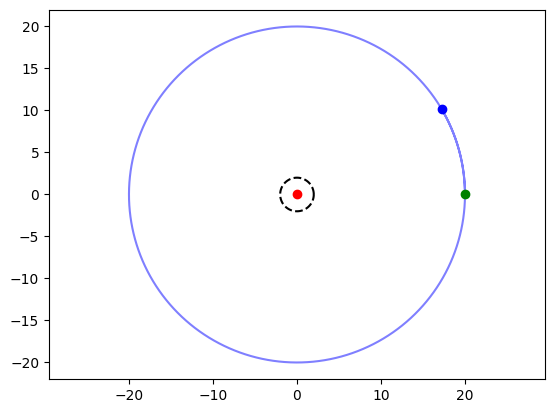

In [8]:
# plt.plot(xs[1], xs[2], '-r', alpha=0.5)
plt.plot(xs2[1], xs2[2], '-b', alpha=0.5)
plt.plot(xs2[1,0], xs2[2,0], 'go')  # posición inicial
plt.plot(xs2[1,-1], xs2[2,-1], 'bo')  # posición final
plt.plot(0, 0, 'ro')
thetas = np.linspace(0, 2*np.pi, 100)
plt.plot(sun.R_s * np.cos(thetas), sun.R_s * np.sin(thetas), 'k--')

plt.axis('equal')
plt.show()

# Simbólico

In [4]:
# replace sp.Function('x^{i}', positive=True)(t) por sp.symbols('x^{i}', positive=True)
from kerrpy.symbolic.coordinates.base import t, xs_p
def replace_func_with_symbol(expr):

    replacements = {
        xs_p[0]: sp.symbols('x^1', positive=True),
        xs_p[1]: sp.symbols('x^2', positive=True),
        xs_p[2]: sp.symbols('x^3', positive=True),
        xs_p[0].diff(t): sp.symbols('\dot{x}^1', real=True),
        xs_p[1].diff(t): sp.symbols('\dot{x}^2', real=True),
        xs_p[2].diff(t): sp.symbols('\dot{x}^3', real=True)
    }
    return expr.subs(replacements)


In [5]:
sph = Spherical()
sph.calculate_relation_vi_dxi_dt()


Matrix([
[                   Derivative(x^1(t), t)],
[            x^1(t)*Derivative(x^2(t), t)],
[x^1(t)*sin(x^2(t))*Derivative(x^3(t), t)]])

In [6]:
# conversion_rule_vel = sp.Eq(
#     sp.Matrix(sp.symbols('dx1_dt_p dx2_dt_p dx3_dt_p')),
#     sph.calculate_cartesian_conversion_rule_velocity()
# )

def optimize_expression(expr):
    expr_rhs = replace_func_with_symbol(expr.rhs)
    expr_rhs, coordinate_substitutions = stn.rename_symbols_of_expr(expr_rhs)
    expr_rhs

    optimized_symbols = expr_rhs.copy()

    substitution_history = []
    
    non_coordinate_subs = {
        symbol: replacement 
        for symbol, replacement in coordinate_substitutions.items() 
        if 'x^' not in str(symbol)
    }
    substitution_history.append(non_coordinate_subs)

    expression_types = [sp.Function, sp.Pow, sp.Pow, sp.Mul]

    for expr_type in expression_types:
        # Encontrar expresiones repetidas del tipo actual
        repeated_expressions = stn._find_repeated_expressions(optimized_symbols, expr_type)
        
        if repeated_expressions:
            # Generar nuevas variables simbólicas para las expresiones repetidas
            expression_substitutions = stn.generate_new_symbols(repeated_expressions)
            optimized_symbols = optimized_symbols.subs(expression_substitutions)
            substitution_history.append(expression_substitutions)
    # print(optimized_symbols)

    return sp.Eq(expr.lhs, optimized_symbols), substitution_history

# convertimos a texto todas las listas "value[0] = value[1]"
def convert_equality_in_txt(variables):
    txt = ""
    for i in range(len(variables)):
        if variables[i][0] == "breakline":
            txt += "\n"
        elif variables[i][0] == "commentline":
            txt += f"# {variables[i][1]}\n"
        else:
            txt += f"{variables[i][0]} = {variables[i][1]}\n"
    return txt



# optimize_expression(conversion_rule_vel)

In [7]:
sun = KerrMetric()
ch = sun.christoffel_symbols().tensor()
ch

[[[0, R_s*(a**4*sin(x^2)**2 - a**4 + a**2*x^1**2*sin(x^2)**2 + x^1**4)/(2*(a**2*cos(x^2)**2 + x^1**2)**2*(-R_s*x^1 + a**2 + x^1**2)), -2*R_s*a**2*x^1*sin(2*x^2)/(a**2*cos(2*x^2) + a**2 + 2*x^1**2)**2, 0], [R_s*(a**4*sin(x^2)**2 - a**4 + a**2*x^1**2*sin(x^2)**2 + x^1**4)/(2*(a**2*cos(x^2)**2 + x^1**2)**2*(-R_s*x^1 + a**2 + x^1**2)), 0, 0, R_s*a*(a**4*cos(x^2)**2 - a**2*x^1**2*cos(x^2)**2 - a**2*x^1**2 - 3*x^1**4)*sin(x^2)**2/(2*(a**2*cos(x^2)**2 + x^1**2)**2*(-R_s*x^1 + a**2 + x^1**2))], [-2*R_s*a**2*x^1*sin(2*x^2)/(a**2*cos(2*x^2) + a**2 + 2*x^1**2)**2, 0, 0, R_s*a**3*x^1*sin(x^2)**3*cos(x^2)/(a**2*cos(x^2)**2 + x^1**2)**2], [0, R_s*a*(a**4*cos(x^2)**2 - a**2*x^1**2*cos(x^2)**2 - a**2*x^1**2 - 3*x^1**4)*sin(x^2)**2/(2*(a**2*cos(x^2)**2 + x^1**2)**2*(-R_s*x^1 + a**2 + x^1**2)), R_s*a**3*x^1*sin(x^2)**3*cos(x^2)/(a**2*cos(x^2)**2 + x^1**2)**2, 0]], [[R_s*(R_s*a**2*x^1*cos(x^2)**2 - R_s*x^1**3 + a**4*cos(x^2)**2 - a**2*x^1**2*cos(x^2)**2 - a**2*x^1**2 + x^1**4)/(2*(a**2*cos(x^2)**2 + x^1*

In [254]:
name = "Gamma"
lh_list = []
dim = ch.shape
for iters in product(*[range(dim[i]) for i in range(len(dim))]):
    lh_list.append(sp.Symbol(f"{name}[{', '.join(map(str, iters))}]"))
lh = sp.NDimArray(lh_list, dim)
lh

[[[Gamma[0, 0, 0], Gamma[0, 0, 1], Gamma[0, 0, 2], Gamma[0, 0, 3]], [Gamma[0, 1, 0], Gamma[0, 1, 1], Gamma[0, 1, 2], Gamma[0, 1, 3]], [Gamma[0, 2, 0], Gamma[0, 2, 1], Gamma[0, 2, 2], Gamma[0, 2, 3]], [Gamma[0, 3, 0], Gamma[0, 3, 1], Gamma[0, 3, 2], Gamma[0, 3, 3]]], [[Gamma[1, 0, 0], Gamma[1, 0, 1], Gamma[1, 0, 2], Gamma[1, 0, 3]], [Gamma[1, 1, 0], Gamma[1, 1, 1], Gamma[1, 1, 2], Gamma[1, 1, 3]], [Gamma[1, 2, 0], Gamma[1, 2, 1], Gamma[1, 2, 2], Gamma[1, 2, 3]], [Gamma[1, 3, 0], Gamma[1, 3, 1], Gamma[1, 3, 2], Gamma[1, 3, 3]]], [[Gamma[2, 0, 0], Gamma[2, 0, 1], Gamma[2, 0, 2], Gamma[2, 0, 3]], [Gamma[2, 1, 0], Gamma[2, 1, 1], Gamma[2, 1, 2], Gamma[2, 1, 3]], [Gamma[2, 2, 0], Gamma[2, 2, 1], Gamma[2, 2, 2], Gamma[2, 2, 3]], [Gamma[2, 3, 0], Gamma[2, 3, 1], Gamma[2, 3, 2], Gamma[2, 3, 3]]], [[Gamma[3, 0, 0], Gamma[3, 0, 1], Gamma[3, 0, 2], Gamma[3, 0, 3]], [Gamma[3, 1, 0], Gamma[3, 1, 1], Gamma[3, 1, 2], Gamma[3, 1, 3]], [Gamma[3, 2, 0], Gamma[3, 2, 1], Gamma[3, 2, 2], Gamma[3, 2, 3]], [G

In [22]:
import re

class ValidExpresion:
    def __init__(self):
        pass


    def make_valid_varname(self, name):
        # reemplazar caracteres no válidos por "_"
        # {'**':'pow', '(':l, ')':l}
        replaces = {
            r"\*\*": "_pow",
            r"\(": "_I",
            r"\)": "I_",
            r"/": "_over_",
            r"\+": "_plus_"
        }

        # replace '\dot{x}^i' by 'dxi_dt'
        name = re.sub(r'\\dot\{x\}\^(-?\d+)', r'dx\1_dt', name)

        for pattern, replacement in replaces.items():
            name = re.sub(pattern, replacement, name)

        # _powN1_powN2 -> _pow#(N1*N2)
        name = re.sub(r'_pow(-?\d+)_pow(-?\d+)', lambda m: f"_pow{int(m.group(1)) * int(m.group(2))}", name)
        name = re.sub(r'[^0-9a-zA-Z_]', '_', name)
        # no empezar con dígito
        if name[0].isdigit():
            name = "_" + name
        return name

    def generate_new_symbols(self, original_symbols):
        new_symbols = {}
        for symbol in original_symbols:
        # reemplazamos 'x^i' por 'xi'
            str_symbol = str(symbol)
            if 'x^' in str_symbol:
                str_symbol = str_symbol.replace('x^', 'x')
            else:
                str_symbol = self.make_valid_varname(str_symbol)

            new_symbols[symbol] = sp.symbols(str_symbol)

        return new_symbols


    def rename_symbols_of_expr(self, expr):
        original_symbols = expr.free_symbols
        coordinate_substitutions = self.generate_new_symbols(original_symbols)
        new_expr = expr.subs(coordinate_substitutions)

        return new_expr, coordinate_substitutions

valid = ValidExpresion()

def optimize_expression(expr):
    expr_rhs = replace_func_with_symbol(expr.rhs)
    expr_rhs, coordinate_substitutions = valid.rename_symbols_of_expr(expr_rhs)
    expr_rhs

    optimized_symbols = expr_rhs.copy()

    substitution_history = []
    
    non_coordinate_subs = {
        symbol: replacement 
        for symbol, replacement in coordinate_substitutions.items() 
        if 'x^' not in str(symbol)
    }
    substitution_history.append(non_coordinate_subs)

    expression_types = [sp.Function, sp.Pow, sp.Pow, sp.Mul]

    for expr_type in expression_types:
        # Encontrar expresiones repetidas del tipo actual
        repeated_expressions = stn._find_repeated_expressions(optimized_symbols, expr_type)
        
        if repeated_expressions:
            # Generar nuevas variables simbólicas para las expresiones repetidas
            expression_substitutions = stn.generate_new_symbols(repeated_expressions)
            optimized_symbols = optimized_symbols.subs(expression_substitutions)
            substitution_history.append(expression_substitutions)
    # print(optimized_symbols)

    all_subs = substitution_history[:2]

    for sub_dict in substitution_history[2:]:
        # ordenamos el dict por la longitud de la cadena del valor, si tienen la misma longitud, por orden alfabético
        order_dict = dict(sorted(sub_dict.items(), key=lambda item: (len(str(item[1])), str(item[1]))))
        
        # vamos a ir de atras (sin tomar el último), verificando si las expresiones anteriores
        # están o no, pera remplazarlas por su value. ej:
        # {a**2:a_2, sin(a**2)**2:sin_a_2_2, cosh(sin(a**2)**2):cosh_sin_a_2_2}
        # la idea es que sea:
        # paso 1: {a**2:a_2, sin(a**2)**2:sin_a_2_2, cosh(sin_a_2_2):cosh_sin_a_2_2}
        # paso 2: {a**2:a_2, sin(a_2)**2:sin_a_2_2, cosh(sin_a_2_2):cosh_sin_a_2_2}

        keys = list(order_dict.keys())
        values = list(order_dict.values())
        n = len(order_dict)
        for i in range(n-1, 0, -1):
            for j in range(i-1, -1, -1):
                if keys[i] != values[j] and keys[i].has(keys[j]):
                    keys[i] = keys[i].subs(keys[j], values[j])
        all_subs.append(dict(zip(keys, values)))


    return sp.Eq(expr.lhs, optimized_symbols), all_subs

# convertimos a texto todas las listas "value[0] = value[1]"
def convert_equality_in_txt(variables):
    txt = ""
    for i in range(len(variables)):
        if variables[i][0] == "breakline":
            txt += "\n"
        elif variables[i][0] == "commentline":
            txt += f"# {variables[i][1]}\n"
        else:
            txt += f"{variables[i][0]} = {variables[i][1]}\n"
    return txt


class TensorCodeGenerator:
    def __init__(self, name, tensor):
        self.tensor = tensor
        self.dim = tensor.shape
        self.name = name

        self.optimize_expression = None

        self.template = open("optimized_calculus_template.txt", "r").read()

    def iter(self):
        return product(*[range(self.dim[i]) for i in range(len(self.dim))])

    def get_expr(self):
        lh_list = []
        for iters in self.iter():
            lh_list.append(sp.Symbol(f"{self.name}[{', '.join(map(str, iters))}]"))
        lh = sp.NDimArray(lh_list, self.dim)

        expr = sp.Eq(lh, self.tensor)
        return expr
    
    def get_vars_and_asignations(self):
        expr = self.get_expr()

        self.optimize_expression = self.optimize_expression if self.optimize_expression!=None else optimize_expression(expr)
        subs_expr, all_subs = self.optimize_expression

        all_subs_done = {}

        proper_vars = []
        for key, value in all_subs[0].items():
            proper_vars.append([str(value), "self." + str(key)])

        all_subs_done.update(all_subs[0])

        auxiliary_vars = []
        for i, sub_ in enumerate(all_subs[1:]):
            # sub_ = dict(sorted(sub_.items(), key=lambda item: str(item[1])))
            for key, value in sub_.items():
                if value not in all_subs_done.values():
                    auxiliary_vars.append([str(value), str(key)])
            i += 1
            all_subs_done.update(sub_)
            
            auxiliary_vars.append(["breakline", ""])

        tensor_asignations = []

        shape = subs_expr.lhs.shape
        last_block = -1 
        tensor_asignations.append((self.name, f"numpy.zeros(shape={shape})"))
        tensor_asignations.append(("commentline", "Tensor components that differ from zero:"))
        for iters in product(*[range(shape[i]) for i in range(len(shape))]):
            if last_block != iters[0]:
                tensor_asignations.append(("breakline", ""))
                tensor_asignations.append(("commentline", "Block " + str(iters[0])))
                last_block = iters[0]
            if expr.rhs[iters] != subs_expr.rhs[iters]:
                tensor_asignations.append((str(expr.lhs[iters]), str(subs_expr.rhs[iters])))

        return proper_vars, auxiliary_vars, tensor_asignations
    
    def get_optimized_equality(self, name_of_function, args=[""], docstring="", extra_lines="", dummy_vars_name=True):
        proper_vars, auxiliary_vars, tensor_asignations = self.get_vars_and_asignations()

        txt = stn.fill_template(
            self.template,
            {   
                "docstring": docstring,
                "proper_vars": convert_equality_in_txt(proper_vars),
                "auxiliary_vars": convert_equality_in_txt(auxiliary_vars),
                "tensor_asignations": convert_equality_in_txt(tensor_asignations),
            }
        )
        
        declaration_line = f"def {name_of_function}(" + ", ".join(args) + "):"

        txt = txt.replace("$name$", declaration_line)
        txt = txt.replace("$tensor_name$", self.name)

        txt = self._set_dummy_vars_name(txt) if dummy_vars_name else txt

        txt = stn.fill_template(txt, {
            "extra_lines": convert_equality_in_txt(extra_lines),
        })
        
        return txt
    
    @staticmethod
    def _set_dummy_vars_name(txt):

        vars_names = re.findall(r"[a-zA-Z0-9_]+? =", txt)
        vars_names = list(set(vars_names))
        vars_replace = {
            var_name.replace(" =", ""): f"v{str(i).zfill(4)}"
            for i, var_name in enumerate(sorted(vars_names, key=len))
        }


        new_txt = txt
        #  Vamos desde -1 hasta 0, reemplazamos en el texto desde donde se encuentra
        #  la variable hasta el final del texto.
        for key, value in sorted(vars_replace.items(), key=lambda item: len(item[0]), reverse=True):
            new_txt = re.sub(rf'(?<!\.)\b{key}\b', value, new_txt)
        
        return new_txt
                

    
# Ts = TensorCodeGenerator("Gamma", ch)
# txt = Ts.get_optimized_equality(
#     "get_christoffel_symbols", 
#     args=["self", "xs"], 
#     docstring="    Calculate the Christoffel symbols at given coordinates xs.",
#     extra_lines=([["_, x1, x2, x3", "xs  # Unpack coordinates"]])
#     )
# print(txt)

In [ ]:
class MetricCodeGenerator:
    def __init__(self, metric_class):
        self.metric_class = metric_class
        
        self.metric = self.metric_class().tensor()
        self.christoffel = self.metric_class().christoffel_symbols().tensor()

        

In [25]:
g__ = sun.metric().tensor()
Gs = TensorCodeGenerator("g", g__)
txt = Gs.get_optimized_equality(
    "get_metric", 
    args=["self", "xs"], 
    docstring="    Calculate the metric tensor at given coordinates xs.",
    extra_lines=([["_, x1, x2, x3", "xs  # Unpack coordinates"]]), dummy_vars_name=True )
print(txt)

# Generated by utils/symbolic_to_numeric.py
def get_metric(self, xs):
    """
    Calculate the metric tensor at given coordinates xs.
    """
    _, x1, x2, x3 = xs  # Unpack coordinates

    v0002 = self.R_s
    v0000 = self.a

    v0005 = sin(x2)
    v0006 = cos(x2)

    v0003 = v0000**2
    v0004 = x1**2
    v0007 = 1/x1
    v0008 = x1**(-2)
    v0010 = v0006**2
    v0009 = v0005**2
    v0013 = 1/(v0003*v0010*v0008 + 1)

    v0011 = 1/v0008

    v0012 = v0003*v0010/v0011
    v0014 = v0002*v0013*v0007*v0000*v0009


    v0001 = numpy.zeros(shape=(4, 4))
    # Tensor components that differ from zero:

    # Block 0
    v0001[0, 0] = -v0002*v0013*v0007 + 1
    v0001[0, 3] = v0014

    # Block 1
    v0001[1, 1] = (-v0012 - 1)/(1 + (-v0002/v0007 - v0003)/v0011)

    # Block 2
    v0001[2, 2] = -v0011*(v0012 + 1)

    # Block 3
    v0001[3, 0] = v0014
    v0001[3, 3] = v0009*(-v0002*v0013*v0007*v0003*v0009 - v0011 - v0003)


    return v0001


In [30]:
g__


[[-R_s/(x^1*(a**2*cos(x^2)**2/x^1**2 + 1)) + 1, 0, 0, R_s*a*sin(x^2)**2/(x^1*(a**2*cos(x^2)**2/x^1**2 + 1))], [0, -(a**2*cos(x^2)**2/x^1**2 + 1)/(1 - (R_s*x^1 + a**2)/x^1**2), 0, 0], [0, 0, -x^1**2*(a**2*cos(x^2)**2/x^1**2 + 1), 0], [R_s*a*sin(x^2)**2/(x^1*(a**2*cos(x^2)**2/x^1**2 + 1)), 0, 0, (-R_s*a**2*sin(x^2)**2/(x^1*(a**2*cos(x^2)**2/x^1**2 + 1)) - a**2 - x^1**2)*sin(x^2)**2]]

In [32]:
x1, x2, x3, a, R_s = sp.symbols('x^1 x^2 x^3 a R_s', real=True)
g_func = sp.lambdify((x1, x2, x3, a, R_s), g__, modules="numpy")
g_func

<function _lambdifygenerated(_Dummy_100450, _Dummy_100449, _Dummy_100448, a, R_s)>

In [33]:
import numpy
from numpy import sin, cos, tan

# Generated by utils/symbolic_to_numeric.py
def get_metric(self, xs):
    """
    Calculate the metric tensor at given coordinates xs.
    """
    _, x1, x2, x3 = xs  # Unpack coordinates

    v0002 = self.R_s
    v0000 = self.a

    v0005 = sin(x2)
    v0006 = cos(x2)

    v0003 = v0000**2
    v0004 = x1**2
    v0007 = 1/x1
    v0008 = x1**(-2)
    v0010 = v0006**2
    v0009 = v0005**2
    v0013 = 1/(v0003*v0010*v0008 + 1)

    v0011 = 1/v0008

    v0012 = v0003*v0010/v0011
    v0014 = v0002*v0013*v0007*v0000*v0009


    v0001 = numpy.zeros(shape=(4, 4))
    # Tensor components that differ from zero:

    # Block 0
    v0001[0, 0] = -v0002*v0013*v0007 + 1
    v0001[0, 3] = v0014

    # Block 1
    v0001[1, 1] = (-v0012 - 1)/(1 + (-v0002/v0007 - v0003)/v0011)

    # Block 2
    v0001[2, 2] = -v0011*(v0012 + 1)

    # Block 3
    v0001[3, 0] = v0014
    v0001[3, 3] = v0009*(-v0002*v0013*v0007*v0003*v0009 - v0011 - v0003)


    return v0001

In [36]:
sun_num = Kerr(mass=_c**2/_G, a=0.5)

xs = [0, 10*sun_num.R_s, np.pi/3, 0]

np.isclose(sun_num.metric(xs), get_metric(sun_num, xs)).all()

np.True_

In [43]:
%timeit get_metric(sun_num, xs)

9.91 μs ± 2.23 μs per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [44]:
%timeit sun_num.metric(xs)

15.6 μs ± 3.4 μs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [ ]:
# Reemplazaremos las variables con nombres genericos varXXXXX
# enumerados en orden, esto es veremos primero las variables, esto es, que sean
# $varname$ = expression
# Las variables son usadas en el resto del texto, por lo que hay
# que reemplazar. Pero, hay variables que contienen texto parecido. por eje:
# var1 = a + b
# var10 = a - b
# var2 = var10
# Así que debemos reemplazar en orden decreciente de longitud de nombre
# para evitar errores de reemplazo.



_set_dummy_vars_name(txt)


'# Generated by utils/symbolic_to_numeric.py\ndef get_christoffel_symbols(self, xs):\n    """\n    Calculate the Christoffel symbols at given coordinates xs.\n    """\n_, x1, x2, v0001 = xs  # Unpack coordinates\n    v0000 = self.a\n    v0002 = self.R_s\n\n    v0017 = cos(x2)\n    v0018 = tan(x2)\n    v0022 = cos(2*x2)\n    v0016 = sin(x2)\n    v0020 = sin(2*x2)\n    v0021 = cos(4*x2)\n\n    v0005 = v0000**2\n    v0004 = v0000**3\n    v0007 = v0000**4\n    v0006 = v0000**6\n    v0010 = x1**2\n    v0009 = x1**3\n    v0008 = x1**4\n    v0011 = x1**5\n    v0013 = x1**6\n    v0015 = v0002**2\n    v0031 = v0017**2\n    v0026 = v0017**4\n    v0030 = v0016**2\n    v0029 = v0016**3\n    v0027 = v0016**4\n    v0033 = 1/v0018\n    v0053 = 1/(-v0002*x1 + v0005 + v0010)\n    v0052 = 1/(v0005*v0031 + v0010)\n    v0054 = (v0005*v0031 + v0010)**(-2)\n    v0055 = (v0005*v0031 + v0010)**(-3)\n    v0057 = 1/(v0005*v0022 + v0005 + 2*v0010)\n    v0059 = (v0005*v0022 + v0005 + 2*v0010)**(-2)\n    v0058 = (

In [45]:
from numpy import sin, cos, tan
import numpy
# Generated by utils/symbolic_to_numeric.py
def get_christoffel_symbols(self, xs):
    """

    """
    _, x1, x2, x3 = xs

    v0000 = self.a
    v0001 = self.R_s

    v0016 = cos(x2)
    v0017 = tan(x2)
    v0021 = cos(2*x2)
    v0015 = sin(x2)
    v0019 = sin(2*x2)
    v0020 = cos(4*x2)

    v0004 = v0000**2
    v0003 = v0000**3
    v0006 = v0000**4
    v0005 = v0000**6
    v0009 = x1**2
    v0008 = x1**3
    v0007 = x1**4
    v0010 = x1**5
    v0012 = x1**6
    v0014 = v0001**2
    v0030 = v0016**2
    v0025 = v0016**4
    v0029 = v0015**2
    v0028 = v0015**3
    v0026 = v0015**4
    v0032 = 1/v0017
    v0052 = 1/(-v0001*x1 + v0004 + v0009)
    v0051 = 1/(v0004*v0030 + v0009)
    v0053 = (v0004*v0030 + v0009)**(-2)
    v0054 = (v0004*v0030 + v0009)**(-3)
    v0056 = 1/(v0004*v0021 + v0004 + 2*v0009)
    v0058 = (v0004*v0021 + v0004 + 2*v0009)**(-2)
    v0057 = (v0004*v0021 + v0004 + 2*v0009)**(-3)
    v0061 = 1/(2*v0004*v0030*v0009 + v0006*v0025 + v0007)
    v0065 = 1/(v0001*v0004*v0030*x1 + v0001*v0008 - v0004*v0030*v0009 + v0004*v0009 + v0006*v0030 - v0007)


    v0011 = -v0006
    v0013 = -v0007
    v0018 = -3*v0007
    v0022 = v0001*v0008
    v0024 = v0001*v0013
    v0023 = -v0020
    v0027 = v0004*v0009
    v0031 = -v0027
    v0033 = 2*v0027
    v0036 = v0006*v0030
    v0034 = v0006*v0029
    v0035 = v0006*v0026
    v0037 = -v0004*v0030
    v0038 = -v0036
    v0040 = -2*v0034
    v0039 = v0006*v0025*x1
    v0041 = v0001*v0004*v0029*x1
    v0043 = v0001*v0037*x1
    v0042 = v0027*v0030
    v0044 = v0027*v0029
    v0045 = -v0042
    v0046 = 2*v0004*v0030*v0008
    v0047 = -2*v0044
    v0048 = v0001*v0045
    v0049 = v0001*v0006*(v0023 + 1)/16
    v0050 = -v0001*v0044/2
    v0055 = v0051*x1
    v0059 = -v0001*v0032*v0053*v0000*x1
    v0060 = -v0056*v0004*v0019
    v0062 = v0001*v0053*v0003*v0016*v0028*x1
    v0063 = -2*v0001*v0058*v0004*v0019*x1
    v0064 = 4*v0001*v0057*v0000*v0019*x1*(v0004 + v0009)
    v0066 = v0001*v0052*v0053*v0000*(v0037 + v0009)/2
    v0067 = v0001*v0052*v0053*(v0011 + v0044 + v0034 + v0007)/2
    v0068 = v0001*v0052*v0053*v0000*v0029*(v0018 + v0045 + v0031 + v0036)/2
    v0069 = v0001*v0054*v0000*v0029*(v0022 + v0043 + v0038 + v0013 + v0042 + v0027)/2
    v0070 = v0061*v0032*(v0041 + v0047 + v0033 + v0040 + v0006 + v0035 + v0007)
    v0071 = v0052*v0053*(v0049 + v0046 + v0048 + v0050 + v0024 + v0039 + v0010)


    v0002 = numpy.zeros(shape=(4, 4, 4))
    # Tensor components that differ from zero:

    # Block 0
    v0002[0, 0, 1] = v0067
    v0002[0, 0, 2] = v0063
    v0002[0, 1, 0] = v0067
    v0002[0, 1, 3] = v0068
    v0002[0, 2, 0] = v0063
    v0002[0, 2, 3] = v0062
    v0002[0, 3, 1] = v0068
    v0002[0, 3, 2] = v0062

    # Block 1
    v0002[1, 0, 0] = v0001*v0054*(v0001*v0004*v0030*x1 - v0022 + v0045 + v0031 + v0036 + v0007)/2
    v0002[1, 0, 3] = v0069
    v0002[1, 1, 1] = v0065*(v0001*v0037/2 + v0001*v0009/2 + v0004*v0030*x1 + v0004*x1)
    v0002[1, 1, 2] = v0060
    v0002[1, 2, 1] = v0060
    v0002[1, 2, 2] = v0055*(v0001*x1 + v0004 - v0009)
    v0002[1, 3, 0] = v0069
    v0002[1, 3, 3] = v0054*v0029*(v0001*v0011*v0029*v0009/2 + 2*v0001*v0004*v0030*v0007 + v0001*v0004*v0029*v0007/2 + v0001*v0006*v0025*v0009 + v0001*v0005*(v0023 + 1)/16 + v0001*v0012 - v0049*v0009 - v0014*v0004*v0029*v0008/2 + v0014*v0006*x1*(v0023 + 1)/16 + 2*v0037*v0010 + v0011*v0025*v0008 + v0004*v0010 + 2*v0036*v0008 + v0005*v0025*x1 - x1**7)

    # Block 2
    v0002[2, 0, 0] = -4*v0001*v0057*v0004*v0019*x1
    v0002[2, 0, 3] = v0064
    v0002[2, 1, 1] = -v0065*v0004*v0016*v0015
    v0002[2, 1, 2] = v0055
    v0002[2, 2, 1] = v0055
    v0002[2, 2, 2] = v0060
    v0002[2, 3, 0] = v0064
    v0002[2, 3, 3] = v0054*v0016*v0015*(v0001*v0011*v0026*x1 + v0001*v0011*x1*(v0023 + 1)/4 - 2*v0022*v0004*v0029 + 2*v0037*v0007 + v0011*v0025*v0009 + 2*v0038*v0009 + v0013*v0004 - v0005*v0025 - v0012)

    # Block 3
    v0002[3, 0, 1] = v0066
    v0002[3, 0, 2] = v0059
    v0002[3, 1, 0] = v0066
    v0002[3, 1, 3] = v0071
    v0002[3, 2, 0] = v0059
    v0002[3, 2, 3] = v0070
    v0002[3, 3, 1] = v0071
    v0002[3, 3, 2] = v0070


    return v0002

In [46]:
kerr_num = Kerr(2, 0.1)

In [47]:
xs = np.array([1.0, 0.1, np.pi/4, 0.0])
ch1 = kerr_num.get_christoffel_symbols(xs)
ch2 = get_christoffel_symbols(kerr_num, xs)

np.isclose(ch1, ch2).all()

np.True_

In [14]:
print(txt)

# Generated by utils/symbolic_to_numeric.py
def get_christoffel_symbols(self):
    """

    """
    a = self.a
    R_s = self.R_s

    cos_Ix2I_ = cos(x2)
    tan_Ix2I_ = tan(x2)
    cos_I2_x2I_ = cos(2*x2)
    sin_Ix2I_ = sin(x2)
    sin_I2_x2I_ = sin(2*x2)
    cos_I4_x2I_ = cos(4*x2)

    a_pow2 = a**2
    a_pow3 = a**3
    a_pow4 = a**4
    a_pow6 = a**6
    x1_pow2 = x1**2
    x1_pow3 = x1**3
    x1_pow4 = x1**4
    x1_pow5 = x1**5
    x1_pow6 = x1**6
    R_s_pow2 = R_s**2
    cos_Ix2I__pow2 = cos_Ix2I_**2
    cos_Ix2I__pow4 = cos_Ix2I_**4
    sin_Ix2I__pow2 = sin_Ix2I_**2
    sin_Ix2I__pow3 = sin_Ix2I_**3
    sin_Ix2I__pow4 = sin_Ix2I_**4
    _1_over_tan_Ix2I_ = 1/tan_Ix2I_
    _1_over__I_R_s_x1__plus__a_pow2__plus__x1_pow2I_ = 1/(-R_s*x1 + a_pow2 + x1_pow2)
    _1_over__Ia_pow2_cos_Ix2I__pow2__plus__x1_pow2I_ = 1/(a_pow2*cos_Ix2I__pow2 + x1_pow2)
    _Ia_pow2_cos_Ix2I__pow2__plus__x1_pow2I__pow_I_2I_ = (a_pow2*cos_Ix2I__pow2 + x1_pow2)**(-2)
    _Ia_pow2_cos_Ix2I__pow2__plus__x1_

In [284]:
sa = TensorCodeGenerator("g", sun.metric().tensor())
print(sa.get_optimized_equality("get_metric_tensor", docstring="Returns the metric tensor g_ij."))

# Generated by utils/symbolic_to_numeric.py
def get_metric_tensor(self):
    """
Returns the metric tensor g_ij.
    """
    R_s = self.R_s
    a = self.a

    sin_Ix2I_ = sin(x2)
    cos_Ix2I_ = cos(x2)

    a_pow2 = a**2
    x1_pow2 = x1**2
    _1_over_x1 = 1/x1
    x1_pow_I_2I_ = x1**(-2)
    cos_Ix2I__pow2 = cos_Ix2I_**2
    sin_Ix2I__pow2 = sin_Ix2I_**2
    _1_over__Ia_pow2_cos_Ix2I__pow2_over_x1_pow2__plus__1I_ = 1/(a_pow2*cos_Ix2I__pow2*x1_pow_I_2I_ + 1)

    _1_over_x1_pow_I_2I_ = 1/x1_pow_I_2I_

    a_pow2_cos_Ix2I__pow2_over__1_over_x1_pow_I_2I_ = a_pow2*cos_Ix2I__pow2/_1_over_x1_pow_I_2I_
    R_s__1_over__Ia_pow2_cos_Ix2I__pow2_over_x1_pow2__plus__1I___1_over_x1_a_sin_Ix2I__pow2 = R_s*_1_over__Ia_pow2_cos_Ix2I__pow2_over_x1_pow2__plus__1I_*_1_over_x1*a*sin_Ix2I__pow2


    Gamma = numpy.zeros(shape=(4, 4))
    # Tensor components that differ from zero:

    # Block 0
    g[0, 0] = -R_s*_1_over__Ia_pow2_cos_Ix2I__pow2_over_x1_pow2__plus__1I_*_1_over_x1 + 1
    g[0, 3] = R_s__

In [ ]:
# Generated by utils/symbolic_to_numeric.py
def get_christoffel_symbols(self):
    """

    """
    R_s = self.R_s
    a = self.a

    sin_I2_x2I_ = sin(2*x2)
    cos_I4_x2I_ = cos(4*x2)
    cos_Ix2I_ = cos(x2)
    cos_I2_x2I_ = cos(2*x2)
    sin_Ix2I_ = sin(x2)
    tan_Ix2I_ = tan(x2)

    a_pow2 = a**2
    a_pow3 = a**3
    a_pow4 = a**4
    a_pow6 = a**6
    x1_pow2 = x1**2
    x1_pow3 = x1**3
    x1_pow4 = x1**4
    x1_pow5 = x1**5
    x1_pow6 = x1**6
    R_s_pow2 = R_s**2
    cos_Ix2I__pow2 = cos_Ix2I_**2
    cos_Ix2I__pow4 = cos_Ix2I_**4
    sin_Ix2I__pow2 = sin_Ix2I_**2
    sin_Ix2I__pow3 = sin_Ix2I_**3
    sin_Ix2I__pow4 = sin_Ix2I_**4
    _1_over_tan_Ix2I_ = 1/tan_Ix2I_
    _1_over__I_R_s_x1__plus__a_pow2__plus__x1_pow2I_ = 1/(-R_s*x1 + a_pow2 + x1_pow2)
    _1_over__Ia_pow2_cos_Ix2I__pow2__plus__x1_pow2I_ = 1/(a_pow2*cos_Ix2I__pow2 + x1_pow2)
    _Ia_pow2_cos_Ix2I__pow2__plus__x1_pow2I__pow_I_2I_ = (a_pow2*cos_Ix2I__pow2 + x1_pow2)**(-2)
    _Ia_pow2_cos_Ix2I__pow2__plus__x1_pow2I__pow_I_3I_ = (a_pow2*cos_Ix2I__pow2 + x1_pow2)**(-3)
    _1_over__Ia_pow2_cos_I2_x2I___plus__a_pow2__plus__2_x1_pow2I_ = 1/(a_pow2*cos_I2_x2I_ + a_pow2 + 2*x1_pow2)
    _Ia_pow2_cos_I2_x2I___plus__a_pow2__plus__2_x1_pow2I__pow_I_2I_ = (a_pow2*cos_I2_x2I_ + a_pow2 + 2*x1_pow2)**(-2)
    _Ia_pow2_cos_I2_x2I___plus__a_pow2__plus__2_x1_pow2I__pow_I_3I_ = (a_pow2*cos_I2_x2I_ + a_pow2 + 2*x1_pow2)**(-3)
    _1_over__Ia_pow4_cos_Ix2I__pow4__plus__2_a_pow2_cos_Ix2I__pow2_x1_pow2__plus__x1_pow4I_ = 1/(2*a_pow2*cos_Ix2I__pow2*x1_pow2 + a_pow4*cos_Ix2I__pow4 + x1_pow4)
    _1_over__IR_s_a_pow2_cos_Ix2I__pow2_x1__plus__R_s_x1_pow3__plus__a_pow4_cos_Ix2I__pow2___a_pow2_cos_Ix2I__pow2_x1_pow2__plus__a_pow2_x1_pow2___x1_pow4I_ = 1/(R_s*a_pow2*cos_Ix2I__pow2*x1 + R_s*x1_pow3 - a_pow2*cos_Ix2I__pow2*x1_pow2 + a_pow2*x1_pow2 + a_pow4*cos_Ix2I__pow2 - x1_pow4)


    _a_pow4 = -a_pow4
    _x1_pow4 = -x1_pow4
    _3_x1_pow4 = -3*x1_pow4
    R_s_x1_pow3 = R_s*x1_pow3
    _R_s_x1_pow4 = R_s*_x1_pow4
    _cos_I4_x2I_ = -cos_I4_x2I_
    a_pow2_x1_pow2 = a_pow2*x1_pow2
    _a_pow2_x1_pow2 = -a_pow2_x1_pow2
    _2_a_pow2_x1_pow2 = 2*a_pow2_x1_pow2
    a_pow4_cos_Ix2I__pow2 = a_pow4*cos_Ix2I__pow2
    a_pow4_sin_Ix2I__pow2 = a_pow4*sin_Ix2I__pow2
    a_pow4_sin_Ix2I__pow4 = a_pow4*sin_Ix2I__pow4
    _a_pow2_cos_Ix2I__pow2 = -a_pow2*cos_Ix2I__pow2
    _a_pow4_cos_Ix2I__pow2 = -a_pow4_cos_Ix2I__pow2
    _2_a_pow4_sin_Ix2I__pow2 = -2*a_pow4_sin_Ix2I__pow2
    a_pow4_cos_Ix2I__pow4_x1 = a_pow4*cos_Ix2I__pow4*x1
    R_s_a_pow2_sin_Ix2I__pow2_x1 = R_s*a_pow2*sin_Ix2I__pow2*x1
    _R_s_a_pow2_cos_Ix2I__pow2_x1 = R_s*_a_pow2_cos_Ix2I__pow2*x1
    a_pow2_cos_Ix2I__pow2_x1_pow2 = a_pow2_x1_pow2*cos_Ix2I__pow2
    a_pow2_sin_Ix2I__pow2_x1_pow2 = a_pow2_x1_pow2*sin_Ix2I__pow2
    _a_pow2_cos_Ix2I__pow2_x1_pow2 = -a_pow2_cos_Ix2I__pow2_x1_pow2
    _2_a_pow2_cos_Ix2I__pow2_x1_pow3 = 2*a_pow2*cos_Ix2I__pow2*x1_pow3
    _2_a_pow2_sin_Ix2I__pow2_x1_pow2 = -2*a_pow2_sin_Ix2I__pow2_x1_pow2
    _R_s_a_pow2_cos_Ix2I__pow2_x1_pow2 = R_s*_a_pow2_cos_Ix2I__pow2_x1_pow2
    R_s_a_pow4__I1___cos_I4_x2I_I__over_16 = R_s*a_pow4*(_cos_I4_x2I_ + 1)/16
    _R_s_a_pow2_sin_Ix2I__pow2_x1_pow2_over_2 = -R_s*a_pow2_sin_Ix2I__pow2_x1_pow2/2
    _1_over__Ia_pow2_cos_Ix2I__pow2__plus__x1_pow2I__x1 = _1_over__Ia_pow2_cos_Ix2I__pow2__plus__x1_pow2I_*x1
    _R_s__1_over_tan_Ix2I___Ia_pow2_cos_Ix2I__pow2__plus__x1_pow2I__pow_I_2I__a_x1 = -R_s*_1_over_tan_Ix2I_*_Ia_pow2_cos_Ix2I__pow2__plus__x1_pow2I__pow_I_2I_*a*x1
    __1_over__Ia_pow2_cos_I2_x2I___plus__a_pow2__plus__2_x1_pow2I__a_pow2_sin_I2_x2I_ = -_1_over__Ia_pow2_cos_I2_x2I___plus__a_pow2__plus__2_x1_pow2I_*a_pow2*sin_I2_x2I_
    R_s__Ia_pow2_cos_Ix2I__pow2__plus__x1_pow2I__pow_I_2I__a_pow3_cos_Ix2I__sin_Ix2I__pow3_x1 = R_s*_Ia_pow2_cos_Ix2I__pow2__plus__x1_pow2I__pow_I_2I_*a_pow3*cos_Ix2I_*sin_Ix2I__pow3*x1
    _2_R_s__Ia_pow2_cos_I2_x2I___plus__a_pow2__plus__2_x1_pow2I__pow_I_2I__a_pow2_sin_I2_x2I__x1 = -2*R_s*_Ia_pow2_cos_I2_x2I___plus__a_pow2__plus__2_x1_pow2I__pow_I_2I_*a_pow2*sin_I2_x2I_*x1
    _4_R_s__Ia_pow2_cos_I2_x2I___plus__a_pow2__plus__2_x1_pow2I__pow_I_3I__a_sin_I2_x2I__x1__Ia_pow2__plus__x1_pow2I_ = 4*R_s*_Ia_pow2_cos_I2_x2I___plus__a_pow2__plus__2_x1_pow2I__pow_I_3I_*a*sin_I2_x2I_*x1*(a_pow2 + x1_pow2)
    R_s__1_over__I_R_s_x1__plus__a_pow2__plus__x1_pow2I___Ia_pow2_cos_Ix2I__pow2__plus__x1_pow2I__pow_I_2I__a__I_a_pow2_cos_Ix2I__pow2__plus__x1_pow2I__over_2 = R_s*_1_over__I_R_s_x1__plus__a_pow2__plus__x1_pow2I_*_Ia_pow2_cos_Ix2I__pow2__plus__x1_pow2I__pow_I_2I_*a*(_a_pow2_cos_Ix2I__pow2 + x1_pow2)/2
    R_s__1_over__I_R_s_x1__plus__a_pow2__plus__x1_pow2I___Ia_pow2_cos_Ix2I__pow2__plus__x1_pow2I__pow_I_2I___Ia_pow2_sin_Ix2I__pow2_x1_pow2__plus__a_pow4_sin_Ix2I__pow2___a_pow4__plus__x1_pow4I__over_2 = R_s*_1_over__I_R_s_x1__plus__a_pow2__plus__x1_pow2I_*_Ia_pow2_cos_Ix2I__pow2__plus__x1_pow2I__pow_I_2I_*(_a_pow4 + a_pow2_sin_Ix2I__pow2_x1_pow2 + a_pow4_sin_Ix2I__pow2 + x1_pow4)/2
    R_s__1_over__I_R_s_x1__plus__a_pow2__plus__x1_pow2I___Ia_pow2_cos_Ix2I__pow2__plus__x1_pow2I__pow_I_2I__a_sin_Ix2I__pow2__I_a_pow2_cos_Ix2I__pow2_x1_pow2___a_pow2_x1_pow2__plus__a_pow4_cos_Ix2I__pow2___3_x1_pow4I__over_2 = R_s*_1_over__I_R_s_x1__plus__a_pow2__plus__x1_pow2I_*_Ia_pow2_cos_Ix2I__pow2__plus__x1_pow2I__pow_I_2I_*a*sin_Ix2I__pow2*(_3_x1_pow4 + _a_pow2_cos_Ix2I__pow2_x1_pow2 + _a_pow2_x1_pow2 + a_pow4_cos_Ix2I__pow2)/2
    R_s__Ia_pow2_cos_Ix2I__pow2__plus__x1_pow2I__pow_I_3I__a_sin_Ix2I__pow2__I_R_s_a_pow2_cos_Ix2I__pow2_x1__plus__R_s_x1_pow3__plus__a_pow2_cos_Ix2I__pow2_x1_pow2__plus__a_pow2_x1_pow2___a_pow4_cos_Ix2I__pow2___x1_pow4I__over_2 = R_s*_Ia_pow2_cos_Ix2I__pow2__plus__x1_pow2I__pow_I_3I_*a*sin_Ix2I__pow2*(R_s_x1_pow3 + _R_s_a_pow2_cos_Ix2I__pow2_x1 + _a_pow4_cos_Ix2I__pow2 + _x1_pow4 + a_pow2_cos_Ix2I__pow2_x1_pow2 + a_pow2_x1_pow2)/2
    _1_over__Ia_pow4_cos_Ix2I__pow4__plus__2_a_pow2_cos_Ix2I__pow2_x1_pow2__plus__x1_pow4I___1_over_tan_Ix2I___IR_s_a_pow2_sin_Ix2I__pow2_x1___2_a_pow2_sin_Ix2I__pow2_x1_pow2__plus__2_a_pow2_x1_pow2___2_a_pow4_sin_Ix2I__pow2__plus__a_pow4_sin_Ix2I__pow4__plus__a_pow4__plus__x1_pow4I_ = _1_over__Ia_pow4_cos_Ix2I__pow4__plus__2_a_pow2_cos_Ix2I__pow2_x1_pow2__plus__x1_pow4I_*_1_over_tan_Ix2I_*(R_s_a_pow2_sin_Ix2I__pow2_x1 + _2_a_pow2_sin_Ix2I__pow2_x1_pow2 + _2_a_pow2_x1_pow2 + _2_a_pow4_sin_Ix2I__pow2 + a_pow4 + a_pow4_sin_Ix2I__pow4 + x1_pow4)
    _1_over__I_R_s_x1__plus__a_pow2__plus__x1_pow2I___Ia_pow2_cos_Ix2I__pow2__plus__x1_pow2I__pow_I_2I___I_R_s_a_pow2_cos_Ix2I__pow2_x1_pow2___R_s_a_pow2_sin_Ix2I__pow2_x1_pow2_over_2__plus__R_s_a_pow4__I1___cos_I4_x2I_I__over_16___R_s_x1_pow4__plus__2_a_pow2_cos_Ix2I__pow2_x1_pow3__plus__a_pow4_cos_Ix2I__pow4_x1__plus__x1_pow5I_ = _1_over__I_R_s_x1__plus__a_pow2__plus__x1_pow2I_*_Ia_pow2_cos_Ix2I__pow2__plus__x1_pow2I__pow_I_2I_*(R_s_a_pow4__I1___cos_I4_x2I_I__over_16 + _2_a_pow2_cos_Ix2I__pow2_x1_pow3 + _R_s_a_pow2_cos_Ix2I__pow2_x1_pow2 + _R_s_a_pow2_sin_Ix2I__pow2_x1_pow2_over_2 + _R_s_x1_pow4 + a_pow4_cos_Ix2I__pow4_x1 + x1_pow5)


    Gamma = numpy.zeros(shape=(4, 4, 4))
    # Tensor components that differ from zero:

    # Block 0
    Gamma[0, 0, 1] = R_s__1_over__I_R_s_x1__plus__a_pow2__plus__x1_pow2I___Ia_pow2_cos_Ix2I__pow2__plus__x1_pow2I__pow_I_2I___Ia_pow2_sin_Ix2I__pow2_x1_pow2__plus__a_pow4_sin_Ix2I__pow2___a_pow4__plus__x1_pow4I__over_2
    Gamma[0, 0, 2] = _2_R_s__Ia_pow2_cos_I2_x2I___plus__a_pow2__plus__2_x1_pow2I__pow_I_2I__a_pow2_sin_I2_x2I__x1
    Gamma[0, 1, 0] = R_s__1_over__I_R_s_x1__plus__a_pow2__plus__x1_pow2I___Ia_pow2_cos_Ix2I__pow2__plus__x1_pow2I__pow_I_2I___Ia_pow2_sin_Ix2I__pow2_x1_pow2__plus__a_pow4_sin_Ix2I__pow2___a_pow4__plus__x1_pow4I__over_2
    Gamma[0, 1, 3] = R_s__1_over__I_R_s_x1__plus__a_pow2__plus__x1_pow2I___Ia_pow2_cos_Ix2I__pow2__plus__x1_pow2I__pow_I_2I__a_sin_Ix2I__pow2__I_a_pow2_cos_Ix2I__pow2_x1_pow2___a_pow2_x1_pow2__plus__a_pow4_cos_Ix2I__pow2___3_x1_pow4I__over_2
    Gamma[0, 2, 0] = _2_R_s__Ia_pow2_cos_I2_x2I___plus__a_pow2__plus__2_x1_pow2I__pow_I_2I__a_pow2_sin_I2_x2I__x1
    Gamma[0, 2, 3] = R_s__Ia_pow2_cos_Ix2I__pow2__plus__x1_pow2I__pow_I_2I__a_pow3_cos_Ix2I__sin_Ix2I__pow3_x1
    Gamma[0, 3, 1] = R_s__1_over__I_R_s_x1__plus__a_pow2__plus__x1_pow2I___Ia_pow2_cos_Ix2I__pow2__plus__x1_pow2I__pow_I_2I__a_sin_Ix2I__pow2__I_a_pow2_cos_Ix2I__pow2_x1_pow2___a_pow2_x1_pow2__plus__a_pow4_cos_Ix2I__pow2___3_x1_pow4I__over_2
    Gamma[0, 3, 2] = R_s__Ia_pow2_cos_Ix2I__pow2__plus__x1_pow2I__pow_I_2I__a_pow3_cos_Ix2I__sin_Ix2I__pow3_x1

    # Block 1
    Gamma[1, 0, 0] = R_s*_Ia_pow2_cos_Ix2I__pow2__plus__x1_pow2I__pow_I_3I_*(R_s*a_pow2*cos_Ix2I__pow2*x1 - R_s_x1_pow3 + _a_pow2_cos_Ix2I__pow2_x1_pow2 + _a_pow2_x1_pow2 + a_pow4_cos_Ix2I__pow2 + x1_pow4)/2
    Gamma[1, 0, 3] = R_s__Ia_pow2_cos_Ix2I__pow2__plus__x1_pow2I__pow_I_3I__a_sin_Ix2I__pow2__I_R_s_a_pow2_cos_Ix2I__pow2_x1__plus__R_s_x1_pow3__plus__a_pow2_cos_Ix2I__pow2_x1_pow2__plus__a_pow2_x1_pow2___a_pow4_cos_Ix2I__pow2___x1_pow4I__over_2
    Gamma[1, 1, 1] = _1_over__IR_s_a_pow2_cos_Ix2I__pow2_x1__plus__R_s_x1_pow3__plus__a_pow4_cos_Ix2I__pow2___a_pow2_cos_Ix2I__pow2_x1_pow2__plus__a_pow2_x1_pow2___x1_pow4I_*(R_s*_a_pow2_cos_Ix2I__pow2/2 + R_s*x1_pow2/2 + a_pow2*cos_Ix2I__pow2*x1 + a_pow2*x1)
    Gamma[1, 1, 2] = __1_over__Ia_pow2_cos_I2_x2I___plus__a_pow2__plus__2_x1_pow2I__a_pow2_sin_I2_x2I_
    Gamma[1, 2, 1] = __1_over__Ia_pow2_cos_I2_x2I___plus__a_pow2__plus__2_x1_pow2I__a_pow2_sin_I2_x2I_
    Gamma[1, 2, 2] = _1_over__Ia_pow2_cos_Ix2I__pow2__plus__x1_pow2I__x1*(R_s*x1 + a_pow2 - x1_pow2)
    Gamma[1, 3, 0] = R_s__Ia_pow2_cos_Ix2I__pow2__plus__x1_pow2I__pow_I_3I__a_sin_Ix2I__pow2__I_R_s_a_pow2_cos_Ix2I__pow2_x1__plus__R_s_x1_pow3__plus__a_pow2_cos_Ix2I__pow2_x1_pow2__plus__a_pow2_x1_pow2___a_pow4_cos_Ix2I__pow2___x1_pow4I__over_2
    Gamma[1, 3, 3] = _Ia_pow2_cos_Ix2I__pow2__plus__x1_pow2I__pow_I_3I_*sin_Ix2I__pow2*(R_s*_a_pow4*sin_Ix2I__pow2*x1_pow2/2 + 2*R_s*a_pow2*cos_Ix2I__pow2*x1_pow4 + R_s*a_pow2*sin_Ix2I__pow2*x1_pow4/2 + R_s*a_pow4*cos_Ix2I__pow4*x1_pow2 + R_s*a_pow6*(_cos_I4_x2I_ + 1)/16 + R_s*x1_pow6 - R_s_a_pow4__I1___cos_I4_x2I_I__over_16*x1_pow2 - R_s_pow2*a_pow2*sin_Ix2I__pow2*x1_pow3/2 + R_s_pow2*a_pow4*x1*(_cos_I4_x2I_ + 1)/16 + 2*_a_pow2_cos_Ix2I__pow2*x1_pow5 + _a_pow4*cos_Ix2I__pow4*x1_pow3 + a_pow2*x1_pow5 + 2*a_pow4_cos_Ix2I__pow2*x1_pow3 + a_pow6*cos_Ix2I__pow4*x1 - x1**7)

    # Block 2
    Gamma[2, 0, 0] = -4*R_s*_Ia_pow2_cos_I2_x2I___plus__a_pow2__plus__2_x1_pow2I__pow_I_3I_*a_pow2*sin_I2_x2I_*x1
    Gamma[2, 0, 3] = _4_R_s__Ia_pow2_cos_I2_x2I___plus__a_pow2__plus__2_x1_pow2I__pow_I_3I__a_sin_I2_x2I__x1__Ia_pow2__plus__x1_pow2I_
    Gamma[2, 1, 1] = -_1_over__IR_s_a_pow2_cos_Ix2I__pow2_x1__plus__R_s_x1_pow3__plus__a_pow4_cos_Ix2I__pow2___a_pow2_cos_Ix2I__pow2_x1_pow2__plus__a_pow2_x1_pow2___x1_pow4I_*a_pow2*cos_Ix2I_*sin_Ix2I_
    Gamma[2, 1, 2] = _1_over__Ia_pow2_cos_Ix2I__pow2__plus__x1_pow2I__x1
    Gamma[2, 2, 1] = _1_over__Ia_pow2_cos_Ix2I__pow2__plus__x1_pow2I__x1
    Gamma[2, 2, 2] = __1_over__Ia_pow2_cos_I2_x2I___plus__a_pow2__plus__2_x1_pow2I__a_pow2_sin_I2_x2I_
    Gamma[2, 3, 0] = _4_R_s__Ia_pow2_cos_I2_x2I___plus__a_pow2__plus__2_x1_pow2I__pow_I_3I__a_sin_I2_x2I__x1__Ia_pow2__plus__x1_pow2I_
    Gamma[2, 3, 3] = _Ia_pow2_cos_Ix2I__pow2__plus__x1_pow2I__pow_I_3I_*cos_Ix2I_*sin_Ix2I_*(R_s*_a_pow4*sin_Ix2I__pow4*x1 + R_s*_a_pow4*x1*(_cos_I4_x2I_ + 1)/4 - 2*R_s_x1_pow3*a_pow2*sin_Ix2I__pow2 + 2*_a_pow2_cos_Ix2I__pow2*x1_pow4 + _a_pow4*cos_Ix2I__pow4*x1_pow2 + 2*_a_pow4_cos_Ix2I__pow2*x1_pow2 + _x1_pow4*a_pow2 - a_pow6*cos_Ix2I__pow4 - x1_pow6)

    # Block 3
    Gamma[3, 0, 1] = R_s__1_over__I_R_s_x1__plus__a_pow2__plus__x1_pow2I___Ia_pow2_cos_Ix2I__pow2__plus__x1_pow2I__pow_I_2I__a__I_a_pow2_cos_Ix2I__pow2__plus__x1_pow2I__over_2
    Gamma[3, 0, 2] = _R_s__1_over_tan_Ix2I___Ia_pow2_cos_Ix2I__pow2__plus__x1_pow2I__pow_I_2I__a_x1
    Gamma[3, 1, 0] = R_s__1_over__I_R_s_x1__plus__a_pow2__plus__x1_pow2I___Ia_pow2_cos_Ix2I__pow2__plus__x1_pow2I__pow_I_2I__a__I_a_pow2_cos_Ix2I__pow2__plus__x1_pow2I__over_2
    Gamma[3, 1, 3] = _1_over__I_R_s_x1__plus__a_pow2__plus__x1_pow2I___Ia_pow2_cos_Ix2I__pow2__plus__x1_pow2I__pow_I_2I___I_R_s_a_pow2_cos_Ix2I__pow2_x1_pow2___R_s_a_pow2_sin_Ix2I__pow2_x1_pow2_over_2__plus__R_s_a_pow4__I1___cos_I4_x2I_I__over_16___R_s_x1_pow4__plus__2_a_pow2_cos_Ix2I__pow2_x1_pow3__plus__a_pow4_cos_Ix2I__pow4_x1__plus__x1_pow5I_
    Gamma[3, 2, 0] = _R_s__1_over_tan_Ix2I___Ia_pow2_cos_Ix2I__pow2__plus__x1_pow2I__pow_I_2I__a_x1
    Gamma[3, 2, 3] = _1_over__Ia_pow4_cos_Ix2I__pow4__plus__2_a_pow2_cos_Ix2I__pow2_x1_pow2__plus__x1_pow4I___1_over_tan_Ix2I___IR_s_a_pow2_sin_Ix2I__pow2_x1___2_a_pow2_sin_Ix2I__pow2_x1_pow2__plus__2_a_pow2_x1_pow2___2_a_pow4_sin_Ix2I__pow2__plus__a_pow4_sin_Ix2I__pow4__plus__a_pow4__plus__x1_pow4I_
    Gamma[3, 3, 1] = _1_over__I_R_s_x1__plus__a_pow2__plus__x1_pow2I___Ia_pow2_cos_Ix2I__pow2__plus__x1_pow2I__pow_I_2I___I_R_s_a_pow2_cos_Ix2I__pow2_x1_pow2___R_s_a_pow2_sin_Ix2I__pow2_x1_pow2_over_2__plus__R_s_a_pow4__I1___cos_I4_x2I_I__over_16___R_s_x1_pow4__plus__2_a_pow2_cos_Ix2I__pow2_x1_pow3__plus__a_pow4_cos_Ix2I__pow4_x1__plus__x1_pow5I_
    Gamma[3, 3, 2] = _1_over__Ia_pow4_cos_Ix2I__pow4__plus__2_a_pow2_cos_Ix2I__pow2_x1_pow2__plus__x1_pow4I___1_over_tan_Ix2I___IR_s_a_pow2_sin_Ix2I__pow2_x1___2_a_pow2_sin_Ix2I__pow2_x1_pow2__plus__2_a_pow2_x1_pow2___2_a_pow4_sin_Ix2I__pow2__plus__a_pow4_sin_Ix2I__pow4__plus__a_pow4__plus__x1_pow4I_


    return Gamma

In [277]:
optimized_symbols = []

for sub_dict in ks[2:]:
    # ordenamos el dict por la longitud de la cadena del valor, si tienen la misma longitud, por orden alfabético
    order_dict = dict(sorted(sub_dict.items(), key=lambda item: (len(str(item[1])), str(item[1]))))
    
    # vamos a ir de atras (sin tomar el último), verificando si las expresiones anteriores
    # están o no, pera remplazarlas por su value. ej:
    # {a**2:a_2, sin(a**2)**2:sin_a_2_2, cosh(sin(a**2)**2):cosh_sin_a_2_2}
    # la idea es que sea:
    # paso 1: {a**2:a_2, sin(a**2)**2:sin_a_2_2, cosh(sin_a_2_2):cosh_sin_a_2_2}
    # paso 2: {a**2:a_2, sin(a_2)**2:sin_a_2_2, cosh(sin_a_2_2):cosh_sin_a_2_2}

    keys = list(order_dict.keys())
    values = list(order_dict.values())
    n = len(order_dict)
    for i in range(n-1, 0, -1):
        for j in range(i-1, -1, -1):
            if keys[i] != values[j] and keys[i].has(keys[j]):
                keys[i] = keys[i].subs(keys[j], values[j])
    optimized_symbols.append(dict(zip(keys, values)))

optimized_symbols

[{a**2: a_pow2,
  a**3: a_pow3,
  a**4: a_pow4,
  a**6: a_pow6,
  x1**2: x1_pow2,
  x1**3: x1_pow3,
  x1**4: x1_pow4,
  x1**5: x1_pow5,
  x1**6: x1_pow6,
  R_s**2: R_s_pow2,
  cos_Ix2I_**2: cos_Ix2I__pow2,
  cos_Ix2I_**4: cos_Ix2I__pow4,
  sin_Ix2I_**2: sin_Ix2I__pow2,
  sin_Ix2I_**3: sin_Ix2I__pow3,
  sin_Ix2I_**4: sin_Ix2I__pow4,
  1/tan_Ix2I_: _1_over_tan_Ix2I_,
  1/(-R_s*x1 + a_pow2 + x1_pow2): _1_over__I_R_s_x1__plus__a_pow2__plus__x1_pow2I_,
  1/(a_pow2*cos_Ix2I__pow2 + x1_pow2): _1_over__Ia_pow2_cos_Ix2I__pow2__plus__x1_pow2I_,
  (a_pow2*cos_Ix2I__pow2 + x1_pow2)**(-2): _Ia_pow2_cos_Ix2I__pow2__plus__x1_pow2I__pow_I_2I_,
  (a_pow2*cos_Ix2I__pow2 + x1_pow2)**(-3): _Ia_pow2_cos_Ix2I__pow2__plus__x1_pow2I__pow_I_3I_,
  1/(a_pow2*cos_I2_x2I_ + a_pow2 + 2*x1_pow2): _1_over__Ia_pow2_cos_I2_x2I___plus__a_pow2__plus__2_x1_pow2I_,
  (a_pow2*cos_I2_x2I_ + a_pow2 + 2*x1_pow2)**(-2): _Ia_pow2_cos_I2_x2I___plus__a_pow2__plus__2_x1_pow2I__pow_I_2I_,
  (a_pow2*cos_I2_x2I_ + a_pow2 + 2*x1_pow2)

In [ ]:
[{a**2: a_pow2,
  a**3: a_pow3,
  a**4: a_pow4,
  a**6: a_pow6,
  x1**2: x1_pow2,
  x1**3: x1_pow3,
  x1**4: x1_pow4,
  x1**5: x1_pow5,
  x1**6: x1_pow6,
  R_s**2: R_s_pow2,
  cos_Ix2I_**2: cos_Ix2I__pow2,
  cos_Ix2I_**4: cos_Ix2I__pow4,
  sin_Ix2I_**2: sin_Ix2I__pow2,
  sin_Ix2I_**3: sin_Ix2I__pow3,
  sin_Ix2I_**4: sin_Ix2I__pow4,
  1/tan_Ix2I_: _1_over_tan_Ix2I_,
  1/(-R_s*x1 + a_pow2 + x1_pow2): _1_over__I_R_s_x1__plus__a_pow2__plus__x1_pow2I_,
  1/(a_pow2*cos_Ix2I__pow2 + x1_pow2): _1_over__Ia_pow2_cos_Ix2I__pow2__plus__x1_pow2I_,
  (a_pow2*cos_Ix2I__pow2 + x1_pow2)**(-2): _Ia_pow2_cos_Ix2I__pow2__plus__x1_pow2I__pow_I_2I_,
  (a_pow2*cos_Ix2I__pow2 + x1_pow2)**(-3): _Ia_pow2_cos_Ix2I__pow2__plus__x1_pow2I__pow_I_3I_,
  1/(a_pow2*cos_I2_x2I_ + a_pow2 + 2*x1_pow2): _1_over__Ia_pow2_cos_I2_x2I___plus__a_pow2__plus__2_x1_pow2I_,
  (a_pow2*cos_I2_x2I_ + a_pow2 + 2*x1_pow2)**(-2): _Ia_pow2_cos_I2_x2I___plus__a_pow2__plus__2_x1_pow2I__pow_I_2I_,
  (a_pow2*cos_I2_x2I_ + a_pow2 + 2*x1_pow2)**(-3): _Ia_pow2_cos_I2_x2I___plus__a_pow2__plus__2_x1_pow2I__pow_I_3I_,
  1/(2*a_pow2*cos_Ix2I__pow2*x1_pow2 + a_pow4*cos_Ix2I__pow4 + x1_pow4): _1_over__Ia_pow4_cos_Ix2I__pow4__plus__2_a_pow2_cos_Ix2I__pow2_x1_pow2__plus__x1_pow4I_,
  1/(R_s*a_pow2*cos_Ix2I__pow2*x1 + R_s*x1_pow3 - a_pow2*cos_Ix2I__pow2*x1_pow2 + a_pow2*x1_pow2 + a_pow4*cos_Ix2I__pow2 - x1_pow4): _1_over__IR_s_a_pow2_cos_Ix2I__pow2_x1__plus__R_s_x1_pow3__plus__a_pow4_cos_Ix2I__pow2___a_pow2_cos_Ix2I__pow2_x1_pow2__plus__a_pow2_x1_pow2___x1_pow4I_},
 {a_pow2**2: a_pow4,
  a_pow2**3: a_pow6,
  x1_pow2**2: x1_pow4,
  x1_pow2**3: x1_pow6,
  cos_Ix2I__pow2**2: cos_Ix2I__pow4,
  sin_Ix2I__pow2**2: sin_Ix2I__pow4},
 {-a_pow4: _a_pow4,
  -x1_pow4: _x1_pow4,
  -3*x1_pow4: _3_x1_pow4,
  R_s*x1_pow3: R_s_x1_pow3,
  R_s*_x1_pow4: _R_s_x1_pow4,
  -cos_I4_x2I_: _cos_I4_x2I_,
  a_pow2*x1_pow2: a_pow2_x1_pow2,
  -a_pow2_x1_pow2: _a_pow2_x1_pow2,
  2*a_pow2_x1_pow2: _2_a_pow2_x1_pow2,
  a_pow4*cos_Ix2I__pow2: a_pow4_cos_Ix2I__pow2,
  a_pow4*sin_Ix2I__pow2: a_pow4_sin_Ix2I__pow2,
  a_pow4*sin_Ix2I__pow4: a_pow4_sin_Ix2I__pow4,
  -a_pow2*cos_Ix2I__pow2: _a_pow2_cos_Ix2I__pow2,
  -a_pow4_cos_Ix2I__pow2: _a_pow4_cos_Ix2I__pow2,
  -2*a_pow4_sin_Ix2I__pow2: _2_a_pow4_sin_Ix2I__pow2,
  a_pow4*cos_Ix2I__pow4*x1: a_pow4_cos_Ix2I__pow4_x1,
  R_s*a_pow2*sin_Ix2I__pow2*x1: R_s_a_pow2_sin_Ix2I__pow2_x1,
  R_s*_a_pow2_cos_Ix2I__pow2*x1: _R_s_a_pow2_cos_Ix2I__pow2_x1,
  a_pow2_x1_pow2*cos_Ix2I__pow2: a_pow2_cos_Ix2I__pow2_x1_pow2,
  a_pow2_x1_pow2*sin_Ix2I__pow2: a_pow2_sin_Ix2I__pow2_x1_pow2,
  -a_pow2_cos_Ix2I__pow2_x1_pow2: _a_pow2_cos_Ix2I__pow2_x1_pow2,
  2*a_pow2*cos_Ix2I__pow2*x1_pow3: _2_a_pow2_cos_Ix2I__pow2_x1_pow3,
  -2*a_pow2_sin_Ix2I__pow2_x1_pow2: _2_a_pow2_sin_Ix2I__pow2_x1_pow2,
  R_s*_a_pow2_cos_Ix2I__pow2_x1_pow2: _R_s_a_pow2_cos_Ix2I__pow2_x1_pow2,
  R_s*a_pow4*(_cos_I4_x2I_ + 1)/16: R_s_a_pow4__I1___cos_I4_x2I_I__over_16,
  -R_s*a_pow2_sin_Ix2I__pow2_x1_pow2/2: _R_s_a_pow2_sin_Ix2I__pow2_x1_pow2_over_2,
  _1_over__Ia_pow2_cos_Ix2I__pow2__plus__x1_pow2I_*x1: _1_over__Ia_pow2_cos_Ix2I__pow2__plus__x1_pow2I__x1,
  -R_s*_1_over_tan_Ix2I_*_Ia_pow2_cos_Ix2I__pow2__plus__x1_pow2I__pow_I_2I_*a*x1: _R_s__1_over_tan_Ix2I___Ia_pow2_cos_Ix2I__pow2__plus__x1_pow2I__pow_I_2I__a_x1,
  -_1_over__Ia_pow2_cos_I2_x2I___plus__a_pow2__plus__2_x1_pow2I_*a_pow2*sin_I2_x2I_: __1_over__Ia_pow2_cos_I2_x2I___plus__a_pow2__plus__2_x1_pow2I__a_pow2_sin_I2_x2I_,
  R_s*_Ia_pow2_cos_Ix2I__pow2__plus__x1_pow2I__pow_I_2I_*a_pow3*cos_Ix2I_*sin_Ix2I__pow3*x1: R_s__Ia_pow2_cos_Ix2I__pow2__plus__x1_pow2I__pow_I_2I__a_pow3_cos_Ix2I__sin_Ix2I__pow3_x1,
  -2*R_s*_Ia_pow2_cos_I2_x2I___plus__a_pow2__plus__2_x1_pow2I__pow_I_2I_*a_pow2*sin_I2_x2I_*x1: _2_R_s__Ia_pow2_cos_I2_x2I___plus__a_pow2__plus__2_x1_pow2I__pow_I_2I__a_pow2_sin_I2_x2I__x1,
  4*R_s*_Ia_pow2_cos_I2_x2I___plus__a_pow2__plus__2_x1_pow2I__pow_I_3I_*a*sin_I2_x2I_*x1*(a_pow2 + x1_pow2): _4_R_s__Ia_pow2_cos_I2_x2I___plus__a_pow2__plus__2_x1_pow2I__pow_I_3I__a_sin_I2_x2I__x1__Ia_pow2__plus__x1_pow2I_,
  R_s*_1_over__I_R_s_x1__plus__a_pow2__plus__x1_pow2I_*_Ia_pow2_cos_Ix2I__pow2__plus__x1_pow2I__pow_I_2I_*a*(_a_pow2_cos_Ix2I__pow2 + x1_pow2)/2: R_s__1_over__I_R_s_x1__plus__a_pow2__plus__x1_pow2I___Ia_pow2_cos_Ix2I__pow2__plus__x1_pow2I__pow_I_2I__a__I_a_pow2_cos_Ix2I__pow2__plus__x1_pow2I__over_2,
  R_s*_1_over__I_R_s_x1__plus__a_pow2__plus__x1_pow2I_*_Ia_pow2_cos_Ix2I__pow2__plus__x1_pow2I__pow_I_2I_*(_a_pow4 + a_pow2_sin_Ix2I__pow2_x1_pow2 + a_pow4_sin_Ix2I__pow2 + x1_pow4)/2: R_s__1_over__I_R_s_x1__plus__a_pow2__plus__x1_pow2I___Ia_pow2_cos_Ix2I__pow2__plus__x1_pow2I__pow_I_2I___Ia_pow2_sin_Ix2I__pow2_x1_pow2__plus__a_pow4_sin_Ix2I__pow2___a_pow4__plus__x1_pow4I__over_2,
  R_s*_1_over__I_R_s_x1__plus__a_pow2__plus__x1_pow2I_*_Ia_pow2_cos_Ix2I__pow2__plus__x1_pow2I__pow_I_2I_*a*sin_Ix2I__pow2*(_3_x1_pow4 + _a_pow2_cos_Ix2I__pow2_x1_pow2 + _a_pow2_x1_pow2 + a_pow4_cos_Ix2I__pow2)/2: R_s__1_over__I_R_s_x1__plus__a_pow2__plus__x1_pow2I___Ia_pow2_cos_Ix2I__pow2__plus__x1_pow2I__pow_I_2I__a_sin_Ix2I__pow2__I_a_pow2_cos_Ix2I__pow2_x1_pow2___a_pow2_x1_pow2__plus__a_pow4_cos_Ix2I__pow2___3_x1_pow4I__over_2,
  R_s*_Ia_pow2_cos_Ix2I__pow2__plus__x1_pow2I__pow_I_3I_*a*sin_Ix2I__pow2*(R_s_x1_pow3 + _R_s_a_pow2_cos_Ix2I__pow2_x1 + _a_pow4_cos_Ix2I__pow2 + _x1_pow4 + a_pow2_cos_Ix2I__pow2_x1_pow2 + a_pow2_x1_pow2)/2: R_s__Ia_pow2_cos_Ix2I__pow2__plus__x1_pow2I__pow_I_3I__a_sin_Ix2I__pow2__I_R_s_a_pow2_cos_Ix2I__pow2_x1__plus__R_s_x1_pow3__plus__a_pow2_cos_Ix2I__pow2_x1_pow2__plus__a_pow2_x1_pow2___a_pow4_cos_Ix2I__pow2___x1_pow4I__over_2,
  _1_over__Ia_pow4_cos_Ix2I__pow4__plus__2_a_pow2_cos_Ix2I__pow2_x1_pow2__plus__x1_pow4I_*_1_over_tan_Ix2I_*(R_s_a_pow2_sin_Ix2I__pow2_x1 + _2_a_pow2_sin_Ix2I__pow2_x1_pow2 + _2_a_pow2_x1_pow2 + _2_a_pow4_sin_Ix2I__pow2 + a_pow4 + a_pow4_sin_Ix2I__pow4 + x1_pow4): _1_over__Ia_pow4_cos_Ix2I__pow4__plus__2_a_pow2_cos_Ix2I__pow2_x1_pow2__plus__x1_pow4I___1_over_tan_Ix2I___IR_s_a_pow2_sin_Ix2I__pow2_x1___2_a_pow2_sin_Ix2I__pow2_x1_pow2__plus__2_a_pow2_x1_pow2___2_a_pow4_sin_Ix2I__pow2__plus__a_pow4_sin_Ix2I__pow4__plus__a_pow4__plus__x1_pow4I_,
  _1_over__I_R_s_x1__plus__a_pow2__plus__x1_pow2I_*_Ia_pow2_cos_Ix2I__pow2__plus__x1_pow2I__pow_I_2I_*(R_s_a_pow4__I1___cos_I4_x2I_I__over_16 + _2_a_pow2_cos_Ix2I__pow2_x1_pow3 + _R_s_a_pow2_cos_Ix2I__pow2_x1_pow2 + _R_s_a_pow2_sin_Ix2I__pow2_x1_pow2_over_2 + _R_s_x1_pow4 + a_pow4_cos_Ix2I__pow4_x1 + x1_pow5): _1_over__I_R_s_x1__plus__a_pow2__plus__x1_pow2I___Ia_pow2_cos_Ix2I__pow2__plus__x1_pow2I__pow_I_2I___I_R_s_a_pow2_cos_Ix2I__pow2_x1_pow2___R_s_a_pow2_sin_Ix2I__pow2_x1_pow2_over_2__plus__R_s_a_pow4__I1___cos_I4_x2I_I__over_16___R_s_x1_pow4__plus__2_a_pow2_cos_Ix2I__pow2_x1_pow3__plus__a_pow4_cos_Ix2I__pow4_x1__plus__x1_pow5I_}]

In [ ]:
# Generated by utils/symbolic_to_numeric.py
def get_christoffel_symbols(self):
    """

    """
    R_s = self.R_s
    a = self.a

    cos_I2_x2I_ = cos(2*x2)
    cos_I4_x2I_ = cos(4*x2)
    cos_Ix2I_ = cos(x2)
    sin_I2_x2I_ = sin(2*x2)
    sin_Ix2I_ = sin(x2)
    tan_Ix2I_ = tan(x2)

    R_s_pow2 = R_s**2
    _1_over__IR_s_a_pow2_cos_Ix2I__pow2_x1__plus__R_s_x1_pow3__plus__a_pow4_cos_Ix2I__pow2___a_pow2_cos_Ix2I__pow2_x1_pow2__plus__a_pow2_x1_pow2___x1_pow4I_ = 1/(R_s*a**2*cos_Ix2I_**2*x1 + R_s*x1**3 + a**4*cos_Ix2I_**2 - a**2*cos_Ix2I_**2*x1**2 + a**2*x1**2 - x1**4)
    _1_over__I_R_s_x1__plus__a_pow2__plus__x1_pow2I_ = 1/(-R_s*x1 + a**2 + x1**2)
    _1_over__Ia_pow2_cos_I2_x2I___plus__a_pow2__plus__2_x1_pow2I_ = 1/(a**2*cos_I2_x2I_ + a**2 + 2*x1**2)
    _1_over__Ia_pow2_cos_Ix2I__pow2__plus__x1_pow2I_ = 1/(a**2*cos_Ix2I_**2 + x1**2)
    _1_over__Ia_pow4_cos_Ix2I__pow4__plus__2_a_pow2_cos_Ix2I__pow2_x1_pow2__plus__x1_pow4I_ = 1/(a**4*cos_Ix2I_**4 + 2*a**2*cos_Ix2I_**2*x1**2 + x1**4)
    _1_over_tan_Ix2I_ = 1/tan_Ix2I_
    _Ia_pow2_cos_I2_x2I___plus__a_pow2__plus__2_x1_pow2I__pow_I_2I_ = (a**2*cos_I2_x2I_ + a**2 + 2*x1**2)**(-2)
    _Ia_pow2_cos_I2_x2I___plus__a_pow2__plus__2_x1_pow2I__pow_I_3I_ = (a**2*cos_I2_x2I_ + a**2 + 2*x1**2)**(-3)
    _Ia_pow2_cos_Ix2I__pow2__plus__x1_pow2I__pow_I_2I_ = (a**2*cos_Ix2I_**2 + x1**2)**(-2)
    _Ia_pow2_cos_Ix2I__pow2__plus__x1_pow2I__pow_I_3I_ = (a**2*cos_Ix2I_**2 + x1**2)**(-3)
    a_pow2 = a**2
    a_pow3 = a**3
    a_pow4 = a**4
    a_pow6 = a**6
    cos_Ix2I__pow2 = cos_Ix2I_**2
    cos_Ix2I__pow4 = cos_Ix2I_**4
    sin_Ix2I__pow2 = sin_Ix2I_**2
    sin_Ix2I__pow3 = sin_Ix2I_**3
    sin_Ix2I__pow4 = sin_Ix2I_**4
    x1_pow2 = x1**2
    x1_pow3 = x1**3
    x1_pow4 = x1**4
    x1_pow5 = x1**5
    x1_pow6 = x1**6


    R_s__1_over__I_R_s_x1__plus__a_pow2__plus__x1_pow2I___Ia_pow2_cos_Ix2I__pow2__plus__x1_pow2I__pow_I_2I___Ia_pow2_sin_Ix2I__pow2_x1_pow2__plus__a_pow4_sin_Ix2I__pow2___a_pow4__plus__x1_pow4I__over_2 = R_s*_1_over__I_R_s_x1__plus__a_pow2__plus__x1_pow2I_*_Ia_pow2_cos_Ix2I__pow2__plus__x1_pow2I__pow_I_2I_*(a_pow2*sin_Ix2I__pow2*x1_pow2 + a_pow4*sin_Ix2I__pow2 - a_pow4 + x1_pow4)/2
    R_s__1_over__I_R_s_x1__plus__a_pow2__plus__x1_pow2I___Ia_pow2_cos_Ix2I__pow2__plus__x1_pow2I__pow_I_2I__a__I_a_pow2_cos_Ix2I__pow2__plus__x1_pow2I__over_2 = R_s*_1_over__I_R_s_x1__plus__a_pow2__plus__x1_pow2I_*_Ia_pow2_cos_Ix2I__pow2__plus__x1_pow2I__pow_I_2I_*a*(-a_pow2*cos_Ix2I__pow2 + x1_pow2)/2
    R_s__1_over__I_R_s_x1__plus__a_pow2__plus__x1_pow2I___Ia_pow2_cos_Ix2I__pow2__plus__x1_pow2I__pow_I_2I__a_sin_Ix2I__pow2__I_a_pow2_cos_Ix2I__pow2_x1_pow2___a_pow2_x1_pow2__plus__a_pow4_cos_Ix2I__pow2___3_x1_pow4I__over_2 = R_s*_1_over__I_R_s_x1__plus__a_pow2__plus__x1_pow2I_*_Ia_pow2_cos_Ix2I__pow2__plus__x1_pow2I__pow_I_2I_*a*sin_Ix2I__pow2*(-a_pow2*cos_Ix2I__pow2*x1_pow2 - a_pow2*x1_pow2 + a_pow4*cos_Ix2I__pow2 - 3*x1_pow4)/2
    R_s__Ia_pow2_cos_Ix2I__pow2__plus__x1_pow2I__pow_I_2I__a_pow3_cos_Ix2I__sin_Ix2I__pow3_x1 = R_s*_Ia_pow2_cos_Ix2I__pow2__plus__x1_pow2I__pow_I_2I_*a_pow3*cos_Ix2I_*sin_Ix2I__pow3*x1
    R_s__Ia_pow2_cos_Ix2I__pow2__plus__x1_pow2I__pow_I_3I__a_sin_Ix2I__pow2__I_R_s_a_pow2_cos_Ix2I__pow2_x1__plus__R_s_x1_pow3__plus__a_pow2_cos_Ix2I__pow2_x1_pow2__plus__a_pow2_x1_pow2___a_pow4_cos_Ix2I__pow2___x1_pow4I__over_2 = R_s*_Ia_pow2_cos_Ix2I__pow2__plus__x1_pow2I__pow_I_3I_*a*sin_Ix2I__pow2*(-R_s*a_pow2*cos_Ix2I__pow2*x1 + R_s*x1_pow3 + a_pow2*cos_Ix2I__pow2*x1_pow2 + a_pow2*x1_pow2 - a_pow4*cos_Ix2I__pow2 - x1_pow4)/2
    R_s_a_pow2_sin_Ix2I__pow2_x1 = R_s*a_pow2*sin_Ix2I__pow2*x1
    R_s_a_pow4__I1___cos_I4_x2I_I__over_16 = R_s*a_pow4*(1 - cos_I4_x2I_)/16
    R_s_x1_pow3 = R_s*x1_pow3
    _1_over__I_R_s_x1__plus__a_pow2__plus__x1_pow2I___Ia_pow2_cos_Ix2I__pow2__plus__x1_pow2I__pow_I_2I___I_R_s_a_pow2_cos_Ix2I__pow2_x1_pow2___R_s_a_pow2_sin_Ix2I__pow2_x1_pow2_over_2__plus__R_s_a_pow4__I1___cos_I4_x2I_I__over_16___R_s_x1_pow4__plus__2_a_pow2_cos_Ix2I__pow2_x1_pow3__plus__a_pow4_cos_Ix2I__pow4_x1__plus__x1_pow5I_ = _1_over__I_R_s_x1__plus__a_pow2__plus__x1_pow2I_*_Ia_pow2_cos_Ix2I__pow2__plus__x1_pow2I__pow_I_2I_*(-R_s*a_pow2*cos_Ix2I__pow2*x1_pow2 - R_s*a_pow2*sin_Ix2I__pow2*x1_pow2/2 + R_s*a_pow4*(1 - cos_I4_x2I_)/16 - R_s*x1_pow4 + 2*a_pow2*cos_Ix2I__pow2*x1_pow3 + a_pow4*cos_Ix2I__pow4*x1 + x1_pow5)
    _1_over__Ia_pow2_cos_Ix2I__pow2__plus__x1_pow2I__x1 = _1_over__Ia_pow2_cos_Ix2I__pow2__plus__x1_pow2I_*x1
    _1_over__Ia_pow4_cos_Ix2I__pow4__plus__2_a_pow2_cos_Ix2I__pow2_x1_pow2__plus__x1_pow4I___1_over_tan_Ix2I___IR_s_a_pow2_sin_Ix2I__pow2_x1___2_a_pow2_sin_Ix2I__pow2_x1_pow2__plus__2_a_pow2_x1_pow2___2_a_pow4_sin_Ix2I__pow2__plus__a_pow4_sin_Ix2I__pow4__plus__a_pow4__plus__x1_pow4I_ = _1_over__Ia_pow4_cos_Ix2I__pow4__plus__2_a_pow2_cos_Ix2I__pow2_x1_pow2__plus__x1_pow4I_*_1_over_tan_Ix2I_*(R_s*a_pow2*sin_Ix2I__pow2*x1 - 2*a_pow2*sin_Ix2I__pow2*x1_pow2 + 2*a_pow2*x1_pow2 - 2*a_pow4*sin_Ix2I__pow2 + a_pow4*sin_Ix2I__pow4 + a_pow4 + x1_pow4)
    _2_R_s__Ia_pow2_cos_I2_x2I___plus__a_pow2__plus__2_x1_pow2I__pow_I_2I__a_pow2_sin_I2_x2I__x1 = -2*R_s*_Ia_pow2_cos_I2_x2I___plus__a_pow2__plus__2_x1_pow2I__pow_I_2I_*a_pow2*sin_I2_x2I_*x1
    _2_a_pow2_cos_Ix2I__pow2_x1_pow3 = 2*a_pow2*cos_Ix2I__pow2*x1_pow3
    _2_a_pow2_sin_Ix2I__pow2_x1_pow2 = -2*a_pow2*sin_Ix2I__pow2*x1_pow2
    _2_a_pow2_x1_pow2 = 2*a_pow2*x1_pow2
    _2_a_pow4_sin_Ix2I__pow2 = -2*a_pow4*sin_Ix2I__pow2
    _3_x1_pow4 = -3*x1_pow4
    _4_R_s__Ia_pow2_cos_I2_x2I___plus__a_pow2__plus__2_x1_pow2I__pow_I_3I__a_sin_I2_x2I__x1__Ia_pow2__plus__x1_pow2I_ = 4*R_s*_Ia_pow2_cos_I2_x2I___plus__a_pow2__plus__2_x1_pow2I__pow_I_3I_*a*sin_I2_x2I_*x1*(a_pow2 + x1_pow2)
    _R_s__1_over_tan_Ix2I___Ia_pow2_cos_Ix2I__pow2__plus__x1_pow2I__pow_I_2I__a_x1 = -R_s*_1_over_tan_Ix2I_*_Ia_pow2_cos_Ix2I__pow2__plus__x1_pow2I__pow_I_2I_*a*x1
    _R_s_a_pow2_cos_Ix2I__pow2_x1 = -R_s*a_pow2*cos_Ix2I__pow2*x1
    _R_s_a_pow2_cos_Ix2I__pow2_x1_pow2 = -R_s*a_pow2*cos_Ix2I__pow2*x1_pow2
    _R_s_a_pow2_sin_Ix2I__pow2_x1_pow2_over_2 = -R_s*a_pow2*sin_Ix2I__pow2*x1_pow2/2
    _R_s_x1_pow4 = -R_s*x1_pow4
    __1_over__Ia_pow2_cos_I2_x2I___plus__a_pow2__plus__2_x1_pow2I__a_pow2_sin_I2_x2I_ = -_1_over__Ia_pow2_cos_I2_x2I___plus__a_pow2__plus__2_x1_pow2I_*a_pow2*sin_I2_x2I_
    _a_pow2_cos_Ix2I__pow2 = -a_pow2*cos_Ix2I__pow2
    _a_pow2_cos_Ix2I__pow2_x1_pow2 = -a_pow2*cos_Ix2I__pow2*x1_pow2
    _a_pow2_x1_pow2 = -a_pow2*x1_pow2
    _a_pow4 = -a_pow4
    _a_pow4_cos_Ix2I__pow2 = -a_pow4*cos_Ix2I__pow2
    _cos_I4_x2I_ = -cos_I4_x2I_
    _x1_pow4 = -x1_pow4
    a_pow2_cos_Ix2I__pow2_x1_pow2 = a_pow2*cos_Ix2I__pow2*x1_pow2
    a_pow2_sin_Ix2I__pow2_x1_pow2 = a_pow2*sin_Ix2I__pow2*x1_pow2
    a_pow2_x1_pow2 = a_pow2*x1_pow2
    a_pow4_cos_Ix2I__pow2 = a_pow4*cos_Ix2I__pow2
    a_pow4_cos_Ix2I__pow4_x1 = a_pow4*cos_Ix2I__pow4*x1
    a_pow4_sin_Ix2I__pow2 = a_pow4*sin_Ix2I__pow2
    a_pow4_sin_Ix2I__pow4 = a_pow4*sin_Ix2I__pow4


    Gamma = numpy.zeros(shape=(4, 4, 4))
    # Tensor components that differ from zero:

    # Block 0
    Gamma[0, 0, 1] = R_s__1_over__I_R_s_x1__plus__a_pow2__plus__x1_pow2I___Ia_pow2_cos_Ix2I__pow2__plus__x1_pow2I__pow_I_2I___Ia_pow2_sin_Ix2I__pow2_x1_pow2__plus__a_pow4_sin_Ix2I__pow2___a_pow4__plus__x1_pow4I__over_2
    Gamma[0, 0, 2] = _2_R_s__Ia_pow2_cos_I2_x2I___plus__a_pow2__plus__2_x1_pow2I__pow_I_2I__a_pow2_sin_I2_x2I__x1
    Gamma[0, 1, 0] = R_s__1_over__I_R_s_x1__plus__a_pow2__plus__x1_pow2I___Ia_pow2_cos_Ix2I__pow2__plus__x1_pow2I__pow_I_2I___Ia_pow2_sin_Ix2I__pow2_x1_pow2__plus__a_pow4_sin_Ix2I__pow2___a_pow4__plus__x1_pow4I__over_2
    Gamma[0, 1, 3] = R_s__1_over__I_R_s_x1__plus__a_pow2__plus__x1_pow2I___Ia_pow2_cos_Ix2I__pow2__plus__x1_pow2I__pow_I_2I__a_sin_Ix2I__pow2__I_a_pow2_cos_Ix2I__pow2_x1_pow2___a_pow2_x1_pow2__plus__a_pow4_cos_Ix2I__pow2___3_x1_pow4I__over_2
    Gamma[0, 2, 0] = _2_R_s__Ia_pow2_cos_I2_x2I___plus__a_pow2__plus__2_x1_pow2I__pow_I_2I__a_pow2_sin_I2_x2I__x1
    Gamma[0, 2, 3] = R_s__Ia_pow2_cos_Ix2I__pow2__plus__x1_pow2I__pow_I_2I__a_pow3_cos_Ix2I__sin_Ix2I__pow3_x1
    Gamma[0, 3, 1] = R_s__1_over__I_R_s_x1__plus__a_pow2__plus__x1_pow2I___Ia_pow2_cos_Ix2I__pow2__plus__x1_pow2I__pow_I_2I__a_sin_Ix2I__pow2__I_a_pow2_cos_Ix2I__pow2_x1_pow2___a_pow2_x1_pow2__plus__a_pow4_cos_Ix2I__pow2___3_x1_pow4I__over_2
    Gamma[0, 3, 2] = R_s__Ia_pow2_cos_Ix2I__pow2__plus__x1_pow2I__pow_I_2I__a_pow3_cos_Ix2I__sin_Ix2I__pow3_x1

    # Block 1
    Gamma[1, 0, 0] = R_s*_Ia_pow2_cos_Ix2I__pow2__plus__x1_pow2I__pow_I_3I_*(R_s*a_pow2*cos_Ix2I__pow2*x1 - R_s_x1_pow3 + _a_pow2_cos_Ix2I__pow2_x1_pow2 + _a_pow2_x1_pow2 + a_pow4_cos_Ix2I__pow2 + x1_pow4)/2
    Gamma[1, 0, 3] = R_s__Ia_pow2_cos_Ix2I__pow2__plus__x1_pow2I__pow_I_3I__a_sin_Ix2I__pow2__I_R_s_a_pow2_cos_Ix2I__pow2_x1__plus__R_s_x1_pow3__plus__a_pow2_cos_Ix2I__pow2_x1_pow2__plus__a_pow2_x1_pow2___a_pow4_cos_Ix2I__pow2___x1_pow4I__over_2
    Gamma[1, 1, 1] = _1_over__IR_s_a_pow2_cos_Ix2I__pow2_x1__plus__R_s_x1_pow3__plus__a_pow4_cos_Ix2I__pow2___a_pow2_cos_Ix2I__pow2_x1_pow2__plus__a_pow2_x1_pow2___x1_pow4I_*(R_s*_a_pow2_cos_Ix2I__pow2/2 + R_s*x1_pow2/2 + a_pow2*cos_Ix2I__pow2*x1 + a_pow2*x1)
    Gamma[1, 1, 2] = __1_over__Ia_pow2_cos_I2_x2I___plus__a_pow2__plus__2_x1_pow2I__a_pow2_sin_I2_x2I_
    Gamma[1, 2, 1] = __1_over__Ia_pow2_cos_I2_x2I___plus__a_pow2__plus__2_x1_pow2I__a_pow2_sin_I2_x2I_
    Gamma[1, 2, 2] = _1_over__Ia_pow2_cos_Ix2I__pow2__plus__x1_pow2I__x1*(R_s*x1 + a_pow2 - x1_pow2)
    Gamma[1, 3, 0] = R_s__Ia_pow2_cos_Ix2I__pow2__plus__x1_pow2I__pow_I_3I__a_sin_Ix2I__pow2__I_R_s_a_pow2_cos_Ix2I__pow2_x1__plus__R_s_x1_pow3__plus__a_pow2_cos_Ix2I__pow2_x1_pow2__plus__a_pow2_x1_pow2___a_pow4_cos_Ix2I__pow2___x1_pow4I__over_2
    Gamma[1, 3, 3] = _Ia_pow2_cos_Ix2I__pow2__plus__x1_pow2I__pow_I_3I_*sin_Ix2I__pow2*(R_s*_a_pow4*sin_Ix2I__pow2*x1_pow2/2 + 2*R_s*a_pow2*cos_Ix2I__pow2*x1_pow4 + R_s*a_pow2*sin_Ix2I__pow2*x1_pow4/2 + R_s*a_pow4*cos_Ix2I__pow4*x1_pow2 + R_s*a_pow6*(_cos_I4_x2I_ + 1)/16 + R_s*x1_pow6 - R_s_a_pow4__I1___cos_I4_x2I_I__over_16*x1_pow2 - R_s_pow2*a_pow2*sin_Ix2I__pow2*x1_pow3/2 + R_s_pow2*a_pow4*x1*(_cos_I4_x2I_ + 1)/16 + 2*_a_pow2_cos_Ix2I__pow2*x1_pow5 + _a_pow4*cos_Ix2I__pow4*x1_pow3 + a_pow2*x1_pow5 + 2*a_pow4_cos_Ix2I__pow2*x1_pow3 + a_pow6*cos_Ix2I__pow4*x1 - x1**7)

    # Block 2
    Gamma[2, 0, 0] = -4*R_s*_Ia_pow2_cos_I2_x2I___plus__a_pow2__plus__2_x1_pow2I__pow_I_3I_*a_pow2*sin_I2_x2I_*x1
    Gamma[2, 0, 3] = _4_R_s__Ia_pow2_cos_I2_x2I___plus__a_pow2__plus__2_x1_pow2I__pow_I_3I__a_sin_I2_x2I__x1__Ia_pow2__plus__x1_pow2I_
    Gamma[2, 1, 1] = -_1_over__IR_s_a_pow2_cos_Ix2I__pow2_x1__plus__R_s_x1_pow3__plus__a_pow4_cos_Ix2I__pow2___a_pow2_cos_Ix2I__pow2_x1_pow2__plus__a_pow2_x1_pow2___x1_pow4I_*a_pow2*cos_Ix2I_*sin_Ix2I_
    Gamma[2, 1, 2] = _1_over__Ia_pow2_cos_Ix2I__pow2__plus__x1_pow2I__x1
    Gamma[2, 2, 1] = _1_over__Ia_pow2_cos_Ix2I__pow2__plus__x1_pow2I__x1
    Gamma[2, 2, 2] = __1_over__Ia_pow2_cos_I2_x2I___plus__a_pow2__plus__2_x1_pow2I__a_pow2_sin_I2_x2I_
    Gamma[2, 3, 0] = _4_R_s__Ia_pow2_cos_I2_x2I___plus__a_pow2__plus__2_x1_pow2I__pow_I_3I__a_sin_I2_x2I__x1__Ia_pow2__plus__x1_pow2I_
    Gamma[2, 3, 3] = _Ia_pow2_cos_Ix2I__pow2__plus__x1_pow2I__pow_I_3I_*cos_Ix2I_*sin_Ix2I_*(R_s*_a_pow4*sin_Ix2I__pow4*x1 + R_s*_a_pow4*x1*(_cos_I4_x2I_ + 1)/4 - 2*R_s_x1_pow3*a_pow2*sin_Ix2I__pow2 + 2*_a_pow2_cos_Ix2I__pow2*x1_pow4 + _a_pow4*cos_Ix2I__pow4*x1_pow2 + 2*_a_pow4_cos_Ix2I__pow2*x1_pow2 + _x1_pow4*a_pow2 - a_pow6*cos_Ix2I__pow4 - x1_pow6)

    # Block 3
    Gamma[3, 0, 1] = R_s__1_over__I_R_s_x1__plus__a_pow2__plus__x1_pow2I___Ia_pow2_cos_Ix2I__pow2__plus__x1_pow2I__pow_I_2I__a__I_a_pow2_cos_Ix2I__pow2__plus__x1_pow2I__over_2
    Gamma[3, 0, 2] = _R_s__1_over_tan_Ix2I___Ia_pow2_cos_Ix2I__pow2__plus__x1_pow2I__pow_I_2I__a_x1
    Gamma[3, 1, 0] = R_s__1_over__I_R_s_x1__plus__a_pow2__plus__x1_pow2I___Ia_pow2_cos_Ix2I__pow2__plus__x1_pow2I__pow_I_2I__a__I_a_pow2_cos_Ix2I__pow2__plus__x1_pow2I__over_2
    Gamma[3, 1, 3] = _1_over__I_R_s_x1__plus__a_pow2__plus__x1_pow2I___Ia_pow2_cos_Ix2I__pow2__plus__x1_pow2I__pow_I_2I___I_R_s_a_pow2_cos_Ix2I__pow2_x1_pow2___R_s_a_pow2_sin_Ix2I__pow2_x1_pow2_over_2__plus__R_s_a_pow4__I1___cos_I4_x2I_I__over_16___R_s_x1_pow4__plus__2_a_pow2_cos_Ix2I__pow2_x1_pow3__plus__a_pow4_cos_Ix2I__pow4_x1__plus__x1_pow5I_
    Gamma[3, 2, 0] = _R_s__1_over_tan_Ix2I___Ia_pow2_cos_Ix2I__pow2__plus__x1_pow2I__pow_I_2I__a_x1
    Gamma[3, 2, 3] = _1_over__Ia_pow4_cos_Ix2I__pow4__plus__2_a_pow2_cos_Ix2I__pow2_x1_pow2__plus__x1_pow4I___1_over_tan_Ix2I___IR_s_a_pow2_sin_Ix2I__pow2_x1___2_a_pow2_sin_Ix2I__pow2_x1_pow2__plus__2_a_pow2_x1_pow2___2_a_pow4_sin_Ix2I__pow2__plus__a_pow4_sin_Ix2I__pow4__plus__a_pow4__plus__x1_pow4I_
    Gamma[3, 3, 1] = _1_over__I_R_s_x1__plus__a_pow2__plus__x1_pow2I___Ia_pow2_cos_Ix2I__pow2__plus__x1_pow2I__pow_I_2I___I_R_s_a_pow2_cos_Ix2I__pow2_x1_pow2___R_s_a_pow2_sin_Ix2I__pow2_x1_pow2_over_2__plus__R_s_a_pow4__I1___cos_I4_x2I_I__over_16___R_s_x1_pow4__plus__2_a_pow2_cos_Ix2I__pow2_x1_pow3__plus__a_pow4_cos_Ix2I__pow4_x1__plus__x1_pow5I_
    Gamma[3, 3, 2] = _1_over__Ia_pow4_cos_Ix2I__pow4__plus__2_a_pow2_cos_Ix2I__pow2_x1_pow2__plus__x1_pow4I___1_over_tan_Ix2I___IR_s_a_pow2_sin_Ix2I__pow2_x1___2_a_pow2_sin_Ix2I__pow2_x1_pow2__plus__2_a_pow2_x1_pow2___2_a_pow4_sin_Ix2I__pow2__plus__a_pow4_sin_Ix2I__pow4__plus__a_pow4__plus__x1_pow4I_


    return Gamma

In [185]:
name = "Gamma"
lh_ch = sp.NDimArray([[[ sp.Symbol(f"{name}[{i}, {j}, {k}]") for k in range(4)] for j in range(4)] for i in range(4)], (4, 4, 4))
expr = sp.Eq(lh_ch, ch)
op = optimize_expression(expr)
op

(Eq([[[Gamma[0, 0, 0], Gamma[0, 0, 1], Gamma[0, 0, 2], Gamma[0, 0, 3]], [Gamma[0, 1, 0], Gamma[0, 1, 1], Gamma[0, 1, 2], Gamma[0, 1, 3]], [Gamma[0, 2, 0], Gamma[0, 2, 1], Gamma[0, 2, 2], Gamma[0, 2, 3]], [Gamma[0, 3, 0], Gamma[0, 3, 1], Gamma[0, 3, 2], Gamma[0, 3, 3]]], [[Gamma[1, 0, 0], Gamma[1, 0, 1], Gamma[1, 0, 2], Gamma[1, 0, 3]], [Gamma[1, 1, 0], Gamma[1, 1, 1], Gamma[1, 1, 2], Gamma[1, 1, 3]], [Gamma[1, 2, 0], Gamma[1, 2, 1], Gamma[1, 2, 2], Gamma[1, 2, 3]], [Gamma[1, 3, 0], Gamma[1, 3, 1], Gamma[1, 3, 2], Gamma[1, 3, 3]]], [[Gamma[2, 0, 0], Gamma[2, 0, 1], Gamma[2, 0, 2], Gamma[2, 0, 3]], [Gamma[2, 1, 0], Gamma[2, 1, 1], Gamma[2, 1, 2], Gamma[2, 1, 3]], [Gamma[2, 2, 0], Gamma[2, 2, 1], Gamma[2, 2, 2], Gamma[2, 2, 3]], [Gamma[2, 3, 0], Gamma[2, 3, 1], Gamma[2, 3, 2], Gamma[2, 3, 3]]], [[Gamma[3, 0, 0], Gamma[3, 0, 1], Gamma[3, 0, 2], Gamma[3, 0, 3]], [Gamma[3, 1, 0], Gamma[3, 1, 1], Gamma[3, 1, 2], Gamma[3, 1, 3]], [Gamma[3, 2, 0], Gamma[3, 2, 1], Gamma[3, 2, 2], Gamma[3, 2, 3]]

In [186]:
# proper variables
subs_expr, all_subs = op

all_subs_done = {}

proper_vars = []
for key, value in all_subs[0].items():
    proper_vars.append([str(value), "self." + str(key)])

all_subs_done.update(all_subs[0])

auxiliary_vars = []
for i, sub_ in enumerate(all_subs[1:]):
    sub_ = dict(sorted(sub_.items(), key=lambda item: str(item[1])))
    for key, value in sub_.items():
        if value not in all_subs_done.values():
            auxiliary_vars.append([str(value), str(key)])
    i += 1
    all_subs_done.update(sub_)
    
    auxiliary_vars.append(["breakline", ""])

tensor_asignations = []

shape = subs_expr.lhs.shape
last_block = -1 
tensor_asignations.append((name, f"numpy.zeros(shape={shape})"))
tensor_asignations.append(("commentline", "Tensor components that differ from zero:"))
for iters in product(*[range(shape[i]) for i in range(len(shape))]):
    if last_block != iters[0]:
        tensor_asignations.append(("breakline", ""))
        tensor_asignations.append(("commentline", "Block " + str(iters[0])))
        last_block = iters[0]
    if expr.rhs[iters] != subs_expr.rhs[iters]:
        tensor_asignations.append((str(expr.lhs[iters]), str(subs_expr.rhs[iters])))
        


In [187]:
name = str(subs_expr.lhs[np.zeros_like(subs_expr.lhs.shape)])
name = name[:name.find("[")]
name

'Gamma'

In [242]:
oct = open("optimized_calculus_template.txt", "r").read()
print(oct)

# Generated by utils/symbolic_to_numeric.py
def $Name$(self):
    """

    $Docstring$
    """

    $proper_vars$

    $auxiliary_vars$

    $tensor_asignations$

    return $tensor_name$


In [ ]:
def get_optimized_equality(proper_vars, auxiliary_vars, tensor_asignations):
    txt = stn.fill_template(
        oct,
        {   
            "Name": 'get_christoffel_symbols',
            "Docstring": '    Calcula los símbolos de Christoffel optimizados.',
            "proper_vars": convert_equality_in_txt(proper_vars),
            "auxiliary_vars": convert_equality_in_txt(auxiliary_vars),
            "tensor_asignations": convert_equality_in_txt(tensor_asignations),
            "tensor_name": name,
        }
    )
    # print(convert_equality_in_txt(auxiliary_vars))
    return txt

a = get_optimized_equality(proper_vars, auxiliary_vars, tensor_asignations)
print(a)

# Generated by utils/symbolic_to_numeric.py
def $Name$(self):
    """
    Calcula los símbolos de Christoffel optimizados.
    """
    R_s = self.R_s
    a = self.a

    cos_I2_x2I_ = cos(2*x2)
    cos_I4_x2I_ = cos(4*x2)
    cos_Ix2I_ = cos(x2)
    sin_I2_x2I_ = sin(2*x2)
    sin_Ix2I_ = sin(x2)
    tan_Ix2I_ = tan(x2)

    R_s_pow2 = R_s**2
    _1_over_tan_Ix2I_ = 1/tan_Ix2I_
    a_pow2 = a**2
    a_pow3 = a**3
    a_pow4 = a**4
    a_pow6 = a**6
    cos_Ix2I__pow2 = cos_Ix2I_**2
    cos_Ix2I__pow4 = cos_Ix2I_**4
    sin_Ix2I__pow2 = sin_Ix2I_**2
    sin_Ix2I__pow3 = sin_Ix2I_**3
    sin_Ix2I__pow4 = sin_Ix2I_**4
    x1_pow2 = x1**2
    x1_pow3 = x1**3
    x1_pow4 = x1**4
    x1_pow5 = x1**5
    x1_pow6 = x1**6


    R_s_a_pow2_cos_Ix2I__pow2_x1 = R_s*a_pow2*cos_Ix2I__pow2*x1
    R_s_a_pow2_sin_Ix2I__pow2_x1 = R_s*a_pow2*sin_Ix2I__pow2*x1
    R_s_a_pow3_cos_Ix2I__sin_Ix2I__pow3_x1_over__Ia_pow2_cos_Ix2I__pow2__plus__x1_pow2I__pow2 = R_s*a_pow3*cos_Ix2I_*sin_Ix2I__pow3*x1/(a_pow2*cos_

In [218]:
rule = ""
for i in range(3):
    rh = expr.rhs[i]
    lh = expr.lhs[i]
    rule += f"{lh} = {sp.simplify(rh)}\n"
rule = rule.replace("x1", "xs[1]").replace("x2", "xs[2]").replace("x3", "xs[3]")
rule = rule.replace("dxs[1]_dt", "dxs_dt[1]").replace("dxs[2]_dt", "dxs_dt[2]").replace("dxs[3]_dt", "dxs_dt[3]")
rule = rule.replace("dxs_dt[1]_p", "dxs_dt_p[1]").replace("dxs_dt[2]_p", "dxs_dt_p[2]").replace("dxs_dt[3]_p", "dxs_dt_p[3]")

print(rule)

[[Gamma[0, 0, 0], Gamma[0, 0, 1], Gamma[0, 0, 2], Gamma[0, 0, 3]], [Gamma[0, 1, 0], Gamma[0, 1, 1], Gamma[0, 1, 2], Gamma[0, 1, 3]], [Gamma[0, 2, 0], Gamma[0, 2, 1], Gamma[0, 2, 2], Gamma[0, 2, 3]], [Gamma[0, 3, 0], Gamma[0, 3, 1], Gamma[0, 3, 2], Gamma[0, 3, 3]]] = [[0, R_s*(a**4*sin(x^2)**2 - a**4 + a**2*x^1**2*sin(x^2)**2 + x^1**4)/(2*(a**2*cos(x^2)**2 + x^1**2)**2*(-R_s*x^1 + a**2 + x^1**2)), -R_s*a**2*x^1*sin(2*x^2)/(2*(a**2*cos(x^2)**2 + x^1**2)**2), 0], [R_s*(a**4*sin(x^2)**2 - a**4 + a**2*x^1**2*sin(x^2)**2 + x^1**4)/(2*(a**2*cos(x^2)**2 + x^1**2)**2*(-R_s*x^1 + a**2 + x^1**2)), 0, 0, -R_s*a*(-a**4*cos(x^2)**2 + a**2*x^1**2*cos(x^2)**2 + a**2*x^1**2 + 3*x^1**4)*sin(x^2)**2/(2*(a**2*cos(x^2)**2 + x^1**2)**2*(-R_s*x^1 + a**2 + x^1**2))], [-R_s*a**2*x^1*sin(2*x^2)/(2*(a**2*cos(x^2)**2 + x^1**2)**2), 0, 0, R_s*a**3*x^1*sin(x^2)**3*cos(x^2)/(a**2*cos(x^2)**2 + x^1**2)**2], [0, -R_s*a*(-a**4*cos(x^2)**2 + a**2*x^1**2*cos(x^2)**2 + a**2*x^1**2 + 3*x^1**4)*sin(x^2)**2/(2*(a**2*cos(x^2)

In [4]:
cyl = Cylindrical()
cyl.calculate_relation_vi_dxi_dt()

Matrix([
[      Derivative(x1(t), t)],
[x1(t)*Derivative(x2(t), t)],
[      Derivative(x3(t), t)]])

In [ ]:
rho = sp.symbols('rho', positive=True)   # r ≥ 0

rho = sp.Function('rho', positive=True)(t)
z = sp.Function('z')(t)

x = rho*sp.cos(x3)
y = rho*sp.sin(x3)
z = z

xs = sp.Matrix([x, y, z])
xs_prime = sp.Matrix([rho, x3, z])

subs_dict = {
    rho : 'x1',
    x3 : 'x2',
    z : 'x3'
}

k2 = calculate_relation_vi_dxi_dt(xs, xs_prime, subs_dict, False)
k2

Matrix([
[       Derivative(rho(t), t)],
[rho(t)*Derivative(phi(t), t)],
[         Derivative(z(t), t)]])

```Python
def to_cartesian(self, alpha):
    t, r, theta, phi = self.t, self.r, self.theta, self.phi
    xa = numpy.sqrt(r**2 + alpha**2)
    sin_norm = xa * numpy.sin(theta)
    x = sin_norm * numpy.cos(phi)
    y = sin_norm * numpy.sin(phi)
    z = r * numpy.cos(theta)
    return numpy.array([t, x, y, z])
```

In [9]:
by = BoyerLindquist()

In [19]:
conversion_rule = by.cartesian_conversion_rule()
conversion_rule = replace_func_with_symbol(conversion_rule)
conversion_rule = stn.rename_symbols_of_expr(conversion_rule)
expr = conversion_rule[0]
expr

rule = ""
for i in range(3):
    rule += f"xs_p[{i+1}] = {str(expr[i])}\n"
rule = rule.replace("x1", "xs[1]").replace("x2", "xs[2]").replace("x3", "xs[3]")

print(rule)

NameError: name 'by' is not defined

In [ ]:
def export_relation_vi_dxi_dt_to_code(coordinate_system):

    # convertion between v^i and dxi/dt
    relation = coordinate_system.calculate_relation_vi_dxi_dt()
    relation = replace_func_with_symbol(relation)
    relation = stn.rename_symbols_of_expr(relation)
    expr = relation[0]

    extra_variables = ""
    for free_sym in expr.free_symbols:
        if 'x' not in str(free_sym):
            extra_variables += f"{free_sym} = self.{free_sym}\n"

    factors = ""
    for i in range(3):
        factor = expr[i]/sp.symbols(f'dx{i+1}_dt')
        factors += f"factor_{i+1} = {factor}\n"

    # fill template

    txt = stn.fill_template(
        stn.template_coordinates,
        {
            'extra_variables': extra_variables,
            'factors': factors
        }
    )
    return txt

factors = export_relation_vi_dxi_dt_to_code(by)
print(factors)

# Generated by utils/symbolic_to_numeric.py
def _get_dxs_dt_form_vs(self):
    """
    Returns the conversion from velocities in the coordinate system and
    derivatives with respect to time t. (dxi_dt = vi / factor_i)
    """
    _, x1, x2, x3 = self.xs
    v1, v2, v3 = self.vs
    a = self.a


    factor_1 = sqrt(a**2*cos(x2)**2 + x1**2)/sqrt(a**2 + x1**2)

    factor_2 = sqrt(a**2*cos(x2)**2 + x1**2)

    factor_3 = sqrt(a**2 + x1**2)*sin(x2)


    dx1_dt = v1 / factor_1
    dx2_dt = v2 / factor_2
    dx3_dt = v3 / factor_3

    return numpy.array([dx1_dt, dx2_dt, dx3_dt])

# Generated by utils/symbolic_to_numeric.py
def _get_vs_form_dxs_dt(self, dxs_dt):
    """
    Returns the conversion from derivatives with respect to time t and
    velocities in the coordinate system (vi = factor_i * dxi_dt).
    """
    _, x1, x2, x3 = self.xs
    dx1_dt, dx2_dt, dx3_dt = dxs_dt
    a = self.a


    factor_1 = sqrt(a**2*cos(x2)**2 + x1**2)/sqrt(a**2 + x1**2)

    factor_2 = sqrt(a**2*cos(x2)*

In [ ]:
x1 = sp.Function('r', positive=True)(t)
x2 = sp.Function('theta', positive=True)(t)
x3 = sp.Function('phi', positive=True)(t)
a = sp.symbols('a', positive=True)

xa = sp.sqrt(x1**2 + a**2)
sin_norm = xa * sp.sin(x2)
x = sin_norm * sp.cos(x3)
y = sin_norm * sp.sin(x3)
z = x1 * sp.cos(x2)

xs = sp.Matrix([x, y, z])
xs_prime = sp.Matrix([x1, x2, x3])

dict_replace = {
    x1 : 'x1',
    x2 : 'x2',
    x3 : 'x3',
    a : 'a'
}

kss = calculate_relation_vi_dxi_dt(xs, xs_prime, dict_replace)
print(kss)

Matrix([[x1_prime_dot*sqrt(a**2*cos(x2)**2 + x1**2)/sqrt(a**2 + x1**2)], [x2_prime_dot*sqrt(a**2*cos(x2)**2 + x1**2)], [x3_prime_dot*sqrt(a**2 + x1**2)*sin(x2)]])
